In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import visuals as vs

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

pd.options.display.max_columns = None

import warnings
warnings.simplefilter('ignore')
import dill

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploring the Data

In [4]:
data = pd.read_csv("data/prosperLoanData_clean.csv")

The data I've imported above is pre-cleaned, and has been previously explored and summarized.  See https://eskrav.github.io/udacity-data-analyst/explore-and-summarize/explore-and-summarize.html, for a full summary of the cleaning process and a visual exploration of the dataset.  

All currently active loans have already been removed from the dataset, as I am interested only in historical loans whose ultimate fate (repayment or default) is already known.  The few loans which were cancelled have been removed from the data, as they do not result in any gain or yield for the lender, and therefore are not of as much interest to the problem at hand, which is helping lenders deciding where to lend their money.

Several new features have already been added to the original data - for example, simple string and numerical binary factors indicating whether the loan was completed or not; a continuous feature indicating what percent of their investment the lenders in fact earned back on the historical loans; and so forth.  Many of these features I will remove early on in this process, as they are redundant with other features, or of no relevance to the task at hand (e.g., they concern information that principally cannot be available to the lender at the time that they are making their decision).

In total, the dataset contains 55084 data points corresponding to individual loans, with 32 continuous and 23 categorical features.  Although the data has already been cleaned, there is still missing data that was not imputed, and non-normally-distributed continuous features which will need to be transformed.  Continuous features will also need to be scaled.

In [5]:
data.sample(10)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating.num,ProsperRating.alpha,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,PercentYield,Completed,Completed.num,CreditScore,CreditHistoryAge
15325,30DE3401841321404D27974,206915,2007-09-25,D,36,Chargedoff,2009-09-05,0.20735,0.2000,0.1900,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Administrative Assistant,Full-time,5.0,False,False,NaN,2007-09-24,620.0,639.0,1987-09-28,10.0,5.0,49.0,7,30.0,3.0,24.0,1.0,0.0,54.0,1.0,1.0,709.0,0.10,6196.0,44.0,0.65,3.0,0.18,"$25,000-49,999",True,2353.916667,075C3401706488229F42BFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1740,1.0,77,19984,2500,2007-10-04,Q4 2007,B6C133995349673495672B1,92.91,1722.38,1030.64,691.74,-28.58,-40.08,1469.36,1469.36,118.54,1.0,1,0,0.0,46,D,-0.291096,Not Completed,0,629.5,20.005479
18745,C14B34000664251381A0D9F,208015,2007-09-27,E,36,Defaulted,2011-02-09,0.28406,0.2725,0.2625,NaN,NaN,NaN,NaN,NaN,NaN,0,CA,Clerical,Full-time,25.0,False,True,875733971567025498A67DF,2007-09-09,560.0,579.0,1995-03-03,5.0,5.0,25.0,3,113.0,0.0,10.0,2.0,141.0,19.0,3.0,0.0,1754.0,1.09,55.0,21.0,0.59,0.0,0.57,"$25,000-49,999",True,2500.000000,8E4D34026910801868E3F6E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131,40.0,77,20248,5000,2007-10-10,Q4 2007,D74E33992556059439443C6,4.60,7802.24,4840.27,2961.97,-90.37,-139.27,159.73,0.00,18.69,1.0,0,0,0.0,91,E,0.550204,Not Completed,0,569.5,12.578082
4274,03273550855952167482993,602810,2012-06-22,NaN,36,Completed,2013-08-13,0.12427,0.0964,0.0864,0.0862,0.0200,0.0662,6.0,A,8.0,3,FL,Sales - Commission,Employed,13.0,False,False,NaN,2012-06-22,720.0,739.0,2004-09-29,6.0,6.0,15.0,4,329.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,14829.0,0.40,21471.0,8.0,1.00,0.0,0.16,"$75,000-99,999",True,7500.000000,1D8E36549081731779986B4,1.0,7.0,7.0,0.0,0.0,12500.0,10457.59,-23.0,0,NaN,21,68980,14500,2012-06-29,Q2 2012,91CA3365116013170041831,465.43,15826.88,14500.00,1326.88,-137.63,0.00,0.00,0.00,0.00,1.0,0,0,0.0,178,A,0.082017,Completed,1,729.5,7.734247
2087,2FD135569906529895A24A9,630558,2012-08-29,NaN,36,Completed,2013-02-12,0.20462,0.1679,0.1579,0.1552,0.0599,0.0953,5.0,B,8.0,1,PA,Professional,Employed,198.0,False,False,NaN,2012-08-29,700.0,719.0,1997-09-25,13.0,9.0,35.0,5,351.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,9068.0,0.63,5292.0,33.0,0.96,0.0,0.22,"$50,000-74,999",True,4666.666667,BBEB3659686775141C16760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,18,73868,5300,2012-09-06,Q3 2012,4FC834303398919442AC2A9,188.41,5663.47,5300.00,363.47,-21.65,0.00,0.00,0.00,0.00,1.0,0,0,0.0,104,B,0.064494,Completed,1,709.5,14.936986
32554,D102340343355972924D77E,

Based on my previous exploration of this data, I am immediately removing those features which are irrelevant to the task at hand, or redundant with other features:

The following are internal loan and borrower identifiers, which are largely redundant with other identifiers, and are of no independent use: `ListingKey`, `ListingNumber`, `LoanKey`, `LoanNumber`, `MemberKey`. Of these, I will keep only `ListingKey` and `MemberKey` for the purposes of identifying individual loans and borrowers, until I have cleaned the data.

The following concern internal group membership, about which there is no further information available (furthermore, most loans do not belong to groups); I will therefore leave these aside for the time being: `CurrentlyInGroup`, `GroupKey`.

The following concern information that is not yet available to the lender at the time they are making the decision of whether to lend money, and therefore cannot serve as a useful feature for the lender, or is not directly informative about whether the loan is closed, or not: `ClosedDate`, `LP_CustomerPayments`, `LP_CustomerPrincipalPayments`, `LP_InterestandFees`, `LP_ServiceFees`, `LP_CollectionFees`, `LP_GrossPrincipalLoss`, `LP_NetPrincipalLoss`, `LP_NonPrincipalRecoverypayments`, `LoanCurrentDaysDelinquent`, `LoanFirstDefaultedCycleNumber`, `LoanMonthsSinceOrigination`, `PercentYield`.

The following are redundant with the `Rating` feature, which combines pre- and post-2009 Prosper rating schemes, as described in the previous data summary: `ProsperRating.num`, `ProsperRating.alpha`, `CreditGrade`.

The following are redundant with the label of interest (`Completed.num`), which indicates whether the loan was repaid in full, or defaulted: `LoanStatus`, `Completed`.  The following are redundant with `CreditScore`, which imputes a single average expected credit score (with minor loss of information): `CreditScoreRangeLower`, `CreditScoreRangeUpper`.  The following is redundant with the loan origination date: `LoanOriginationQuarter`.  The following is redundant with the borrower rate: `BorrowerAPR`.  The following is redundant with monthly income, which as a continuous feature is more easily interpretable: `IncomeRange`.  The following is redundant with age of credit history at the time the loan was originated: `FirstRecordedCreditLine`.

Almost all loans are completely funded (`PercentFunded`).

In [6]:
redundant_irrelevant = ["ListingNumber", "LoanKey", "LoanNumber", "LoanStatus", "ClosedDate",
                       "ProsperRating.num", "ProsperRating.alpha", "CreditScoreRangeLower", 
                       "CreditScoreRangeUpper", "LoanOriginationQuarter", "LP_CustomerPayments", 
                       "LP_CustomerPrincipalPayments", "LP_InterestandFees", "LP_ServiceFees", 
                       "LP_CollectionFees", "LP_GrossPrincipalLoss", "LP_NetPrincipalLoss", 
                       "LP_NonPrincipalRecoverypayments", "PercentFunded", "PercentYield", "Completed", 
                       "LoanCurrentDaysDelinquent", "LoanFirstDefaultedCycleNumber", 
                       "LoanMonthsSinceOrigination", "BorrowerAPR", "CurrentlyInGroup", "GroupKey", 
                       "IncomeRange", "CreditGrade", "FirstRecordedCreditLine"]

data.drop(redundant_irrelevant, axis=1, inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55084 entries, 0 to 55083
Data columns (total 57 columns):
ListingKey                             55084 non-null object
ListingCreationDate                    55084 non-null object
Term                                   55084 non-null int64
BorrowerRate                           55084 non-null float64
LenderYield                            55084 non-null float64
EstimatedEffectiveYield                26005 non-null float64
EstimatedLoss                          26005 non-null float64
EstimatedReturn                        26005 non-null float64
ProsperScore                           26005 non-null float64
ListingCategory.num                    55084 non-null int64
BorrowerState                          49572 non-null object
Occupation                             52819 non-null object
EmploymentStatus                       52832 non-null object
EmploymentStatusDuration               47473 non-null float64
IsBorrowerHomeowner             

First, I convert the dates to continuous timestamps, as the methods I use are not able to handle datetime objects:

In [8]:
data['ListingCreationDate'] = pd.to_datetime(data['ListingCreationDate']).astype(np.int64)
data['DateCreditPulled'] = pd.to_datetime(data['DateCreditPulled']).astype(np.int64)
data['LoanOriginationDate'] = pd.to_datetime(data['LoanOriginationDate']).astype(np.int64)

Below, I examine features with null values, and infer from existing values if they can/should be imputed (e.g., an `NA` may represent a 0 for some features, if 0's are not generally coded, but would be expected to show up naturally):

In [9]:
data_num_missing = data.isna().sum()
data_num_missing

ListingKey                                 0
ListingCreationDate                        0
Term                                       0
BorrowerRate                               0
LenderYield                                0
EstimatedEffectiveYield                29079
EstimatedLoss                          29079
EstimatedReturn                        29079
ProsperScore                           29079
ListingCategory.num                        0
BorrowerState                           5512
Occupation                              2265
EmploymentStatus                        2252
EmploymentStatusDuration                7611
IsBorrowerHomeowner                        0
DateCreditPulled                           0
CurrentCreditLines                      7600
OpenCreditLines                         7600
TotalCreditLinespast7years               696
OpenRevolvingAccounts                      0
OpenRevolvingMonthlyPayment                0
InquiriesLast6Months                     696
TotalInqui

In [10]:
# percent of data missing per label:
data.isna().mean().round(4) * 100

ListingKey                              0.00
ListingCreationDate                     0.00
Term                                    0.00
BorrowerRate                            0.00
LenderYield                             0.00
EstimatedEffectiveYield                52.79
EstimatedLoss                          52.79
EstimatedReturn                        52.79
ProsperScore                           52.79
ListingCategory.num                     0.00
BorrowerState                          10.01
Occupation                              4.11
EmploymentStatus                        4.09
EmploymentStatusDuration               13.82
IsBorrowerHomeowner                     0.00
DateCreditPulled                        0.00
CurrentCreditLines                     13.80
OpenCreditLines                        13.80
TotalCreditLinespast7years              1.26
OpenRevolvingAccounts                   0.00
OpenRevolvingMonthlyPayment             0.00
InquiriesLast6Months                    1.26
TotalInqui

In [11]:
# value counts for feature of choice
data.TradesOpenedLast6Months.value_counts()

0.0     23139
1.0     13692
2.0      6265
3.0      2540
4.0      1055
5.0       440
6.0       220
7.0        87
8.0        41
9.0        21
11.0       12
10.0       12
12.0        8
13.0        5
14.0        2
17.0        2
15.0        2
20.0        1
Name: TradesOpenedLast6Months, dtype: int64

In [12]:
data.describe()

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatusDuration,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Completed.num,CreditScore,CreditHistoryAge
count,5.508400e+04,55084.000000,55084.000000,55084.000000,26005.000000,26005.000000,26005.000000,26005.000000,55084.000000,47473.000000,5.508400e+04,47484.000000,47484.000000,54388.000000,55084.000000,55084.000000,54388.000000,53929.000000,54388.000000,47466.000000,54097.000000,54388.000000,47484.000000,4.748400e+04,47484.000000,47544.000000,47544.000000,47544.000000,47544.000000,50854.000000,55084.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10442.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,54494.000000,54388.000000
mean,1.247579e+18,36.942851,0.200423,0.190292,0.176231,0.093795,0.107539,6.265987,2.407578,80.895878,1.247556e+18,9.568634,8.337861,25.276164,6.078389,325.307403,2.051850,7.166608,0.906229,1050.814962,4.571658,0.331029,0.023713,1.568936e+04,0.530446,10844.170411,21.786808,0.856399,0.909326,0.289866,5054.723018,1.332764,20.078850,19.486099,0.544074,0.048202,7104.678315,2332.674796,1.146811,6261.892746,1.248817e+18,223.729882,0.089391,0.046111,33.589037,104.897665,0.691199,681.246247,14.670098
std,6.899523e+16,7.333480,0.081291,0.080726,0.081519,0.055062,0.038377,2.319612,3.397823,84.669661,6.921332e+16,5.582143,4.985417,14.268205,4.528996,448.839320,3.147988,8.214843,2.595972,6676.861621,10.689471,0.790619,0.180400,3.401072e+04,0.350780,21869.026283,12.456163,0.174057,1.240458,0.736738,5711.051112,0.676027,15.871918,15.466862,2.151244,0.509123,6395.297342,3285.130455,50.913387,5217.758039,6.904301e+16,185.727523,0.453767,0.327691,422.191018,108.893346,0.462003,81.908137,7.554535
min,1.131494e+18,12.000000,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,0.000000,0.000000,1.131494e+18,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-194.000000,1000.000000,1.132013e+18,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.500000,0.019178
25%,1.186963e+18,36.000000,0.135000,0.125000,0.110600,0.052000,0.078000,5.000000,0.000000,21.000000,1.186358e+18,6.000000,5.000000,15.000000,3.000000,60.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.614000e+03,0.210000,506.000000,13.000000,0.770000,0.000000,0.130000,2810.604167,1.000000,9.000000,9.000000,0.000000,0.000000,3000.000000,0.000000,-32.000000,2600.000000,1.187914e+18,98.290000,0.000000,0.000000,0.000000,31.000000,0.000000,649.500000,9.416438
50%,1.219277e+18,36.000000,0.194500,0.182550,0.171500,0.098000,0.114400,6.000000,1.000000,52.000000,1.219190e+18,9.000000,8.000000,23.000000,5.000000,183.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.073000e+03,0.560000,3245.500000,20.000000,0.920000,1.000000,0.200000,4166.666667,1.000000,15.000000,14.000000,0.000000,0.000000,5000.000000,1098.020000,0.000000,4500.000000,1.220

### Data Imputation

`EstimatedEffectiveYield` was a measure not available prior to mid-2009.  However, it measures the borrower rate minus expected fees, which can be imputed.  Given the data is not normally distributed (which will be examined further below), I will impute missing data with the median difference between borrower rate and estimated effective yield, as implemented in https://www.kaggle.com/jschnessl/prosper-analysis/notebook:

In [13]:
data[data.EstimatedEffectiveYield.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
50344,AF523422340402366EB58D4,1213315200000000000,36,0.2000,0.1900,NaN,NaN,NaN,NaN,4,KY,Other,Full-time,47.0,True,1212624000000000000,12.0,11.0,24.0,6,247.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4387.0,0.56,2316.0,24.0,1.00,3.0,0.50,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1213660800000000000,E53634225122902807C7B29,74.33,0,0,0.0,32,A,1,729.5,9.830137
37991,A43A3386094992706D3DC7C,1176076800000000000,36,0.2370,0.2270,NaN,NaN,NaN,NaN,0,MI,Sales - Commission,Full-time,10.0,True,1176076800000000000,10.0,10.0,12.0,6,429.0,3.0,8.0,0.0,0.0,0.0,0.0,0.0,12858.0,0.71,5061.0,12.0,0.83,3.0,0.19,True,4916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500,1176422400000000000,78803385352541067D877EA,175.84,0,0,0.0,35,D,1,609.5,6.306849
1821,479E3384826510956101BF3,1175472000000000000,36,0.1424,0.1324,NaN,NaN,NaN,NaN,0,WA,Other,Full-time,9.0,False,1174262400000000000,8.0,7.0,20.0,3,40.0,1.0,8.0,0.0,0.0,5.0,0.0,0.0,943.0,0.87,96.0,13.0,0.69,0.0,0.23,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1176163200000000000,506C33851688627195414A0,34.29,0,0,0.0,22,C,1,649.5,13.460274
21777,4D6834199441034602DB902,1210723200000000000,36,0.1000,0.0900,NaN,NaN,NaN,NaN,4,MA,Computer Programmer,Full-time,24.0,False,1210723200000000000,17.0,13.0,22.0,4,79.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,1035.0,0.00,1255.0,22.0,0.72,2.0,0.18,True,6000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1211846400000000000,824134139671780667EC278,127.80,0,0,0.0,98,A,1,729.5,7.846575
24557,A95734212137570286E2CDB,1210723200000000000,36,0.1105,0.1005,NaN,NaN,NaN,NaN,5,WA,Administrative Assistant,Full-time,9.0,True,1210723200000000000,8.0,8.0,17.0,6,729.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,49244.0,0.85,8156.0,15.0,1.00,0.0,0.32,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1211846400000000000,6F5B3389535523781ADE586,65.52,0,0,0.0,51,B,1,689.5,7.224658


In [14]:
estimated_fees = (data["BorrowerRate"] - data["EstimatedEffectiveYield"]).median()
data["EstimatedEffectiveYield"].fillna(data["BorrowerRate"] - estimated_fees, inplace=True)
data["EstimatedEffectiveYield"].isnull().sum()

0

It's unclear how `EstimatedLoss` is computed.  Given the potential importance of this feature, and the difficulty in imputing it -- as well as the clear dependance on other features, such as risk measures -- I will not attempt to impute this feature, and will look for an algorithm robust to missing values, or simply leave this feature out.  The other potential solution would be to analyze pre-mid-2009 and post-mid-2009 datasets separately.  Ideally, one may want to do linear regression to infer likely values, but that is currently beyond the scope of this project.

In [15]:
data[data.EstimatedLoss.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
2026,05D53419524872151A66E80,1210032000000000000,36,0.3300,0.3200,0.3064,NaN,NaN,NaN,1,UT,Sales - Commission,Full-time,3.0,True,1210032000000000000,10.0,7.0,36.0,5,772.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,23279.0,0.49,8608.0,32.0,0.78,0.0,0.34,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1210896000000000000,FA833420290638402C0CE22,661.67,0,0,0.0,198,C,0,649.5,12.380822
41616,44BD3417599842295F51B34,1206576000000000000,36,0.2504,0.2404,0.2268,NaN,NaN,NaN,1,UT,Sales - Retail,Full-time,45.0,True,1206403200000000000,9.0,5.0,21.0,4,349.0,1.0,14.0,0.0,0.0,0.0,0.0,0.0,5211.0,0.97,69.0,19.0,0.57,0.0,0.19,True,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1207612800000000000,6B673416538742896A83AAC,119.34,0,0,0.0,34,E,1,589.5,12.449315
26858,D9C23426371549085A930D9,1215388800000000000,36,0.3290,0.3190,0.3054,NaN,NaN,NaN,1,OH,Nurse (RN),Full-time,20.0,False,1214092800000000000,7.0,7.0,44.0,10,145.0,2.0,10.0,6.0,17097.0,35.0,1.0,0.0,4661.0,0.22,11050.0,41.0,0.60,0.0,0.16,True,4750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1216252800000000000,9AB1341262775050347C817,42.65,1,0,0.0,30,E,1,569.5,15.194521
19433,EEF933663391486404BD370,1148688000000000000,36,0.2700,0.2650,0.2464,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,1148688000000000000,NaN,NaN,39.0,0,0.0,0.0,NaN,3.0,NaN,24.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,True,5791.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6500,1149811200000000000,D79F3364828330163E79A0F,246.81,0,0,0.0,67,E,1,589.5,26.087671
50267,830D34098477725548021B1,1200441600000000000,36,0.0800,0.0800,0.0564,NaN,NaN,NaN,7,CA,Other,Retired,264.0,False,1200441600000000000,7.0,7.0,12.0,7,141.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4869.0,0.12,35331.0,12.0,1.00,0.0,0.14,True,3083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1201132800000000000,B9FE34108853585384E6C6E,125.35,0,0,0.0,24,AA,1,809.5,36.317808


`EstimatedReturn` is the difference between estimated yield and estimated loss, and cannot be computed without the latter.  I will treat this feature similarly to `EstimatedLoss`.

In [16]:
data[data.EstimatedReturn.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
13659,34B133933690246809F2067,1183939200000000000,36,0.0900,0.085,0.0664,NaN,NaN,NaN,0,MD,Teacher,Full-time,45.0,True,1183939200000000000,8.0,7.0,36.0,4,60.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1172.0,0.24,380.0,11.0,0.91,1.0,0.42,True,3083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8600,1185235200000000000,9ED333664312172229290C6,273.48,0,0,0.0,251,AA,1,829.5,16.873973
41998,FCD633922829691154F71EF,1181520000000000000,36,0.1325,0.125,0.1089,NaN,NaN,NaN,0,GA,Other,Full-time,4.0,True,1180828800000000000,11.0,5.0,20.0,5,283.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,8712.0,0.80,2100.0,18.0,0.83,1.0,0.28,True,2334.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1182988800000000000,68E83391903561106B3334B,507.22,0,0,0.0,301,A,1,729.5,17.720548
23741,B2A833931684510746C41F8,1182729600000000000,36,0.1600,0.145,0.1364,NaN,NaN,NaN,0,UT,Sales - Commission,Full-time,25.0,False,1181779200000000000,10.0,4.0,44.0,3,31.0,14.0,26.0,0.0,0.0,0.0,1.0,0.0,673.0,0.13,4336.0,41.0,0.85,2.0,0.24,True,6000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000,1184198400000000000,0AE23391826535402F9BB46,878.93,0,0,0.0,434,A,0,729.5,15.224658
39298,7C7D33794425391979F8E2B,1169596800000000000,36,0.2600,0.225,0.2364,NaN,NaN,NaN,0,AL,Nurse (RN),Not available,NaN,True,1169510400000000000,NaN,NaN,27.0,1,20.0,14.0,24.0,3.0,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.01,True,6.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1170720000000000000,0BEC3374676341662FB7B9E,80.58,0,0,0.0,41,HR,0,489.5,27.416438
19242,79B8337206199172560E3C7,1162252800000000000,36,0.0700,0.065,0.0464,NaN,NaN,NaN,0,MN,Other,Not available,NaN,True,1161129600000000000,NaN,NaN,36.0,9,0.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,True,6666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1163116800000000000,6CBD3365451213106F81084,30.88,0,0,0.0,17,AA,1,849.5,22.032877


`ProsperScore` is a post-2009 measure.  In my exploratory analysis, it seemed that it might not be entirely redundant with the various Prosper ratings.  I don't believe there is any good way to impute this feature, and will either omit it from the model, or use a model robust to missing values.

In [17]:
data[data.ProsperScore.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
27402,535433945031004131440F2,1184371200000000000,36,0.201,0.186,0.1774,NaN,NaN,NaN,0,IL,Tradesman - Plumber,Full-time,12.0,False,1184371200000000000,6.0,5.0,15.0,4,58.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8538.0,0.61,5262.0,15.0,1.00,0.0,0.38000,True,2860.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1185494400000000000,B5403388803386100553097,372.15,0,0,0.0,99,B,1,689.5,5.326027
2381,0F42336540122316830885C,1146700800000000000,36,0.075,0.070,0.0514,NaN,NaN,NaN,0,MI,NaN,NaN,NaN,False,1146700800000000000,NaN,NaN,32.0,0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05359,True,7000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1147305600000000000,386033663311650401EA95B,31.11,0,0,0.0,8,AA,1,809.5,12.934247
43393,BF753407007693493602C2D,1196726400000000000,36,0.220,0.210,0.1964,NaN,NaN,NaN,1,MS,Sales - Retail,Full-time,171.0,False,1217980800000000000,14.0,11.0,45.0,9,301.0,2.0,6.0,0.0,0.0,5.0,1.0,0.0,7814.0,0.86,690.0,41.0,0.78,2.0,0.35000,True,2416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1218758400000000000,73AF340633528543909B549,45.83,0,0,0.0,55,D,1,629.5,14.805479
22969,DE843422098319694566880,1211414400000000000,36,0.125,0.115,0.1014,NaN,NaN,NaN,1,MO,Other,Not employed,4.0,True,1211414400000000000,27.0,27.0,47.0,19,1608.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0,69069.0,0.48,73767.0,41.0,1.00,5.0,NaN,True,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1212364800000000000,03D03421091604528B9B112,167.27,0,0,0.0,165,A,1,749.5,14.736986
45112,B5313429891362395CEA39E,1219795200000000000,36,0.221,0.211,0.1974,NaN,NaN,NaN,7,PA,Sales - Commission,Full-time,17.0,False,1219795200000000000,10.0,10.0,31.0,2,45.0,3.0,6.0,0.0,0.0,4.0,0.0,0.0,75.0,0.12,525.0,12.0,0.69,2.0,0.21000,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1220486400000000000,6A8434293420340504067AC,191.21,0,0,0.0,118,B,0,689.5,7.939726


`BorrowerState` cannot be imputed.  Unknown values can be labeled as such; however, given the number of feature levels, and no clear expectations for how this feature will affect reliability, the states may need to be grouped into more meaningful geographical regions or categories prior to use.  I leave this for future work, and remove this label for the time being.

In [18]:
data[data.BorrowerState.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
4328,D30D3364846692512963D3B,1152748800000000000,36,0.16,0.155,0.1364,NaN,NaN,NaN,0,NaN,Professional,Not available,NaN,True,1152748800000000000,NaN,NaN,14.0,6,216.0,1.0,10.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,True,4000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000,1153958400000000000,7210336570039809962C6B8,281.26,0,0,0.0,122,D,0,629.5,7.153425
45961,AE443402936913216332C60,1193184000000000000,36,0.15,0.140,0.1264,NaN,NaN,NaN,0,NaN,Realtor,Full-time,45.0,True,1191974400000000000,19.0,19.0,44.0,18,1847.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,63682.0,0.95,2277.0,36.0,1.0,1.0,NaN,False,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18500,1194307200000000000,6FEC340123832665047EDE0,641.31,0,0,0.0,527,B,0,689.5,20.572603
17013,B55E33726442210043FA522,1163548800000000000,36,0.17,0.155,0.1464,NaN,NaN,NaN,0,NaN,Other,Not available,NaN,False,1162512000000000000,NaN,NaN,12.0,6,329.0,4.0,7.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1164585600000000000,81D5337023098468871A914,178.26,0,0,0.0,40,E,1,569.5,7.797260
8307,A8D83378369504694B5B773,1167436800000000000,36,0.29,0.285,0.2664,NaN,NaN,NaN,0,NaN,Clerical,Not available,NaN,False,1166745600000000000,NaN,NaN,22.0,5,142.0,9.0,20.0,6.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.71,True,158.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1168387200000000000,FB1433725305222750E10A0,50.29,0,0,0.0,11,HR,0,529.5,9.728767
33551,72333376963489600C33587,1166313600000000000,36,0.15,0.145,0.1264,NaN,NaN,NaN,0,NaN,Nurse (RN),Not available,NaN,True,1166313600000000000,NaN,NaN,8.0,2,15.0,7.0,20.0,2.0,NaN,6.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,True,266.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1167177600000000000,492B337283264515358F9EA,19.08,0,0,0.0,13,HR,1,509.5,19.164384


In [19]:
data.drop(columns="BorrowerState", axis=1, inplace=True)

`Occupation` cannot be imputed.  Unknown values can be labeled as such, but as with state, known values would need to be grouped meaningfully (e.g. by working class, minimally) to be informative.  I likewise leave this for future work, and for now drop this feature from the dataset.

In [20]:
data[data.Occupation.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
26008,ED733366439427935BC968B,1146528000000000000,36,0.1183,0.1095,0.0947,NaN,NaN,NaN,0,NaN,NaN,NaN,True,1146528000000000000,NaN,NaN,38.0,0,0.0,17.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18609,True,6406.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17000,1147219200000000000,A58033645920864229A1AE8,554.36,0,0,0.0,163,AA,1,829.5,20.098630
23531,1C773365946820909D2656D,1148515200000000000,36,0.2875,0.2825,0.2639,NaN,NaN,NaN,0,NaN,NaN,NaN,True,1148515200000000000,NaN,NaN,42.0,0,0.0,11.0,NaN,10.0,NaN,65.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13000,True,13416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1149638400000000000,23C43365998709587AAED71,250.62,0,0,0.0,50,E,0,569.5,10.238356
16712,323B336460819933383A616,1143072000000000000,36,0.1400,0.1300,0.1164,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1142294400000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09636,True,6000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12000,1144368000000000000,F27E33663337310489C8F7D,410.13,0,0,0.0,98,B,1,NaN,NaN
19818,4AF933653467264701EB44C,1140739200000000000,36,0.0945,0.0895,0.0709,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1140739200000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02168,True,14583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1141603200000000000,2D1533657587231946E6BAE,96.03,0,0,0.0,38,C,1,NaN,NaN
16778,B97F3378978792427DC5D23,1167955200000000000,36,0.1800,0.1750,0.1564,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1167868800000000000,NaN,NaN,20.0,4,10.0,0.0,8.0,9.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25000,True,3900.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1168473600000000000,9A1A3364452983321EE26CB,139.76,0,0,0.0,36,D,1,609.5,6.564384


In [21]:
data.drop(columns="Occupation", axis=1, inplace=True)

`EmploymentStatus` cannot be imputed.  Unknown values will be labeled as such.

In [22]:
data[data.EmploymentStatus.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
54054,EE26336591271203057F534,1145923200000000000,36,0.1325,0.1275,0.1089,NaN,NaN,NaN,0,NaN,NaN,False,1145923200000000000,NaN,NaN,20.0,0,0.0,2.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03689,True,2750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1147046400000000000,A4B233661320016588B2646,101.44,0,0,0.0,84,C,1,669.5,23.243836
51796,C598336485417985062660F,1152230400000000000,36,0.2250,0.1950,0.2014,NaN,NaN,NaN,0,NaN,NaN,False,1151452800000000000,NaN,NaN,27.0,8,174.0,4.0,12.0,1.0,NaN,14.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17000,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1153958400000000000,5A853364946486127A3C5A1,153.80,0,0,0.0,85,E,0,569.5,25.495890
19320,B6E73366056348939D8801F,1132444800000000000,36,0.1200,0.1150,0.0964,NaN,NaN,NaN,0,NaN,NaN,False,1132444800000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.29069,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1132876800000000000,B4183364632797286CA209B,498.21,0,0,0.0,6,C,1,NaN,NaN
11366,10ED33660627603208854CF,1146873600000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,NaN,NaN,False,1146873600000000000,NaN,NaN,43.0,0,0.0,2.0,NaN,20.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10356,True,2083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1147305600000000000,8A063365586345863D2E34B,97.75,0,0,0.0,24,D,0,609.5,20.413699
17695,76F433655280278364F681E,1155772800000000000,36,0.1430,0.1330,0.1194,NaN,NaN,NaN,0,NaN,NaN,False,1155772800000000000,NaN,NaN,12.0,4,107.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20000,True,1750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7300,1156291200000000000,55E93364654740601F77211,250.56,0,0,0.0,58,B,1,709.5,5.139726


In [23]:
data["EmploymentStatus"].fillna("Unknown", inplace=True)
data["EmploymentStatus"].isnull().sum()

0

I will impute `EmploymentStatusDuration` with the median value for this variable.  I would also consider dropping all missing rows, potentially, expecially if there were also missing values in other difficult-to-impute features.  Another possibility, to be explored in the future, is using linear regression to impute these values based on features judged likely to be relevant (e.g., income, occupation, home ownership).  Alternately, an algorithm robust to missing values may be able to handle this data.

In [24]:
data[data.EmploymentStatusDuration.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
31578,B607338090371057571A4EA,1170374400000000000,36,0.1840,0.1640,0.1604,NaN,NaN,NaN,0,Not available,NaN,False,1170288000000000000,NaN,NaN,27.0,1,47.0,8.0,12.0,0.0,NaN,19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14,True,9500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1172188800000000000,209C337922217365991D457,545.30,0,0,0.0,426,D,0,629.5,16.227397
43564,244E3366013894055B2AE79,1154390400000000000,36,0.1700,0.1600,0.1464,NaN,NaN,NaN,0,Not available,NaN,True,1154390400000000000,NaN,NaN,20.0,4,425.0,2.0,6.0,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.39,True,2372.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1154649600000000000,0F4B3365580686300092422,106.96,0,0,0.0,27,B,1,709.5,15.676712
12297,2E1E33792869719219854D4,1168992000000000000,36,0.2690,0.2340,0.2454,NaN,NaN,NaN,0,Not available,NaN,False,1167523200000000000,NaN,NaN,38.0,9,208.0,14.0,15.0,5.0,NaN,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.41,True,6675.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3350,1170201600000000000,811533763872274039AAB8C,0.00,0,0,0.0,57,E,0,569.5,17.473973
15243,844A33756035850923F944D,1166572800000000000,36,0.0790,0.0740,0.0554,NaN,NaN,NaN,0,Not available,NaN,False,1166400000000000000,NaN,NaN,10.0,3,129.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14,True,1564.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1167782400000000000,83783376471673845A09DB8,93.87,0,0,0.0,110,A,1,729.5,10.035616
51735,DF8C3366076618938F046B6,1147305600000000000,36,0.1339,0.1289,0.1103,NaN,NaN,NaN,0,Unknown,NaN,False,1147305600000000000,NaN,NaN,18.0,0,0.0,0.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,True,4767.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1148256000000000000,34A63365058555694AF97F9,118.59,0,0,0.0,73,C,1,669.5,9.539726


In [25]:
median_employment_status_duration = data["EmploymentStatusDuration"].median()
data["EmploymentStatusDuration"].fillna(median_employment_status_duration, inplace=True)
data["EmploymentStatusDuration"].isnull().sum()

0

It's unclear what the right course of action here is, but I will impute missing `CurrentCreditLines` with median values.

In [26]:
data[data.CurrentCreditLines.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
33519,0760336678091259277F520,1155772800000000000,36,0.2200,0.2150,0.1964,NaN,NaN,NaN,0,Not available,52.0,False,1154908800000000000,NaN,NaN,21.0,6,1849.0,13.0,23.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06000,True,80000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12000,1156291200000000000,15D233649249958425BEFF0,458.29,0,0,0.0,87,E,1,569.5,11.052055
27724,71243365079384429E8634E,1150070400000000000,36,0.1065,0.0990,0.0829,NaN,NaN,NaN,0,Unknown,52.0,True,1149033600000000000,NaN,NaN,10.0,5,136.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28000,True,4750.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1151884800000000000,6D50336604863587835A559,481.82,0,0,0.0,195,AA,1,769.5,14.290411
36837,497433643818695923C542B,1150416000000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1149724800000000000,NaN,NaN,5.0,4,143.0,1.0,3.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,4750.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1152576000000000000,D7553366196891000487DB7,111.49,0,0,0.0,64,D,1,609.5,4.893151
48063,F29033652477380737A205A,1146528000000000000,36,0.1275,0.1225,0.1039,NaN,NaN,NaN,0,Unknown,52.0,True,1146528000000000000,NaN,NaN,35.0,0,0.0,6.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02819,True,15500.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1147132800000000000,CC613365999904054634F27,167.87,0,0,0.0,44,B,1,709.5,17.095890
22392,A452336620779504731C9FF,1155168000000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1155168000000000000,NaN,NaN,3.0,0,0.0,4.0,11.0,0.0,NaN,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09000,True,3012.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1155859200000000000,066133657462509132182C8,55.75,0,0,0.0,23,HR,1,509.5,6.120548


In [27]:
median_credit_lines = data["CurrentCreditLines"].median()
data["CurrentCreditLines"].fillna(median_credit_lines, inplace=True)
data["CurrentCreditLines"].isnull().sum()

0

Same for `OpenCreditLines`.

In [28]:
data[data.OpenCreditLines.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
21824,D92333647005429853E3945,1147132800000000000,36,0.200,0.195,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1147132800000000000,9.0,NaN,19.0,0,0.0,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,True,7083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1147824000000000000,2E6533652684133149A4E1A,55.75,0,0,0.0,26,E,0,549.5,10.164384
1218,41383376986739989448CB4,1166745600000000000,36,0.150,0.140,0.1264,NaN,NaN,NaN,0,Not available,52.0,True,1165881600000000000,9.0,NaN,37.0,12,248.0,6.0,17.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27,True,6833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000,1168214400000000000,499C3374597517383E368BD,693.31,0,0,0.0,122,AA,0,829.5,16.632877
50741,95EA3378319093952A7622A,1167264000000000000,36,0.150,0.140,0.1264,NaN,NaN,NaN,0,Not available,52.0,False,1166572800000000000,9.0,NaN,24.0,9,489.0,1.0,8.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,True,3500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1167868800000000000,44DD337186873068458F6F2,104.00,0,0,0.0,2,D,0,609.5,12.416438
2452,4CA233754728969562D2664,1164844800000000000,36,0.085,0.080,0.0614,NaN,NaN,NaN,0,Not available,52.0,False,1164499200000000000,9.0,NaN,12.0,2,42.0,4.0,5.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,True,3208.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1165449600000000000,808C3375516860286394296,31.57,0,0,0.0,10,A,1,729.5,5.408219
38673,57633378300488262E63839,1168300800000000000,36,0.240,0.225,0.2164,NaN,NaN,NaN,0,Not available,52.0,True,1167350400000000000,9.0,NaN,25.0,0,0.0,1.0,13.0,17.0,NaN,27.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,True,2684.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1168992000000000000,CBF63372253880297F9173C,39.23,0,0,0.0,7,HR,0,509.5,11.134247


In [29]:
median_open_credit_lines = data["OpenCreditLines"].median()
data["OpenCreditLines"].fillna(median_open_credit_lines, inplace=True)
data["OpenCreditLines"].isnull().sum()

0

Same for `TotalCreditLinespast7years`.

In [30]:
data[data.TotalCreditLinespast7years.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
24648,906933647967182552C743F,1142467200000000000,36,0.1300,0.1250,0.1064,NaN,NaN,NaN,0,Unknown,52.0,False,1142380800000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08087,True,1666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1142899200000000000,D4223365109152011B6885C,134.78,0,0,0.0,71,C,0,NaN,NaN
1610,42083366023268939EBC25E,1141689600000000000,36,0.1500,0.1300,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1141171200000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12720,True,2083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1142380800000000000,B906336475417750338C047,104.00,0,0,0.0,17,D,0,NaN,NaN
47192,734533648826697888D8F2C,1141862400000000000,36,0.2500,0.2325,0.2264,NaN,NaN,NaN,0,Unknown,52.0,False,1141171200000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16023,True,2666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1142208000000000000,2D0C336524003525059C53A,119.28,0,0,0.0,12,E,1,NaN,NaN
14628,715533652949741663F64DB,1143417600000000000,36,0.0975,0.0900,0.0739,NaN,NaN,NaN,0,Unknown,52.0,False,1143158400000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.32388,True,4416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1144368000000000000,3208336545937634142957E,96.48,0,0,0.0,63,AA,1,NaN,NaN
49340,F4EC3365596988055F0E00C,1145145600000000000,36,0.1575,0.1525,0.1339,NaN,NaN,NaN,0,Unknown,52.0,False,1144540800000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19088,True,4416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1145836800000000000,77613364673881122D26103,70.07,0,0,0.0,15,D,1,NaN,NaN


In [31]:
median_7_credit_lines = data["TotalCreditLinespast7years"].median()
data["TotalCreditLinespast7years"].fillna(median_7_credit_lines, inplace=True)
data["TotalCreditLinespast7years"].isnull().sum()

0

I will impute missing values in `InquiriesLast6Months` with median values.

In [32]:
data[data.InquiriesLast6Months.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
40988,3FB6336460563296173DA0A,1144195200000000000,36,0.1575,0.1450,0.1339,NaN,NaN,NaN,0,Unknown,52.0,False,1144022400000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10281,True,3500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2250,1144886400000000000,72BB3366105179888418920,78.83,0,0,0.0,28,D,1,NaN,NaN
33079,E78C337357937481052FF6C,1162425600000000000,36,0.1999,0.1949,0.1763,NaN,NaN,NaN,0,Unknown,52.0,False,1161734400000000000,9.0,8.0,23.0,1,10.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1125,1163548800000000000,E6053365271253871689297,41.80,0,0,0.0,15,E,1,589.5,NaN
6932,100B33727754992160EB6AF,1163462400000000000,36,0.1700,0.1450,0.1464,NaN,NaN,NaN,0,Not available,52.0,False,1163376000000000000,9.0,8.0,23.0,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1164585600000000000,93093372394776513B2C784,42.78,0,0,0.0,15,NC,0,9.5,NaN
54462,DC813364854588550A92223,1139961600000000000,36,0.1375,0.1250,0.1139,NaN,NaN,NaN,0,Unknown,52.0,False,1139961600000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13213,True,3000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7000,1140566400000000000,B8643365386687319C2A257,238.39,0,0,0.0,15,D,0,NaN,NaN
1554,8B0B3366311860742E5B108,1141862400000000000,36,0.0940,0.0890,0.0704,NaN,NaN,NaN,0,Unknown,52.0,False,1141171200000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16808,True,10416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14500,1143158400000000000,29D13366248149610D66567,463.80,0,0,0.0,161,A,0,NaN,NaN


In [33]:
median_inquiries = data["InquiriesLast6Months"].median()
data["InquiriesLast6Months"].fillna(median_inquiries, inplace=True)
data["InquiriesLast6Months"].isnull().sum()

0

I will impute missing values in `TotalInquiries` with median values.

In [34]:
data[data.TotalInquiries.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
11211,B9023364905420612EEA2C9,1144368000000000000,36,0.1500,0.1400,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1142899200000000000,9.0,8.0,23.0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05111,True,4500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1145232000000000000,09C2336550011508893F708,207.99,0,0,0.0,29,C,1,NaN,NaN
420,02373365894954374C37C9C,1148428800000000000,36,0.1520,0.1470,0.1284,NaN,NaN,NaN,0,Unknown,52.0,True,1148428800000000000,9.0,8.0,18.0,0,0.0,2.0,NaN,0.0,NaN,20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08000,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1149552000000000000,788633656138806947FF4C2,173.82,0,0,0.0,83,C,1,649.5,11.169863
47444,2F6033644734580211EBADD,1145750400000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,Unknown,52.0,True,1145750400000000000,9.0,8.0,18.0,0,0.0,4.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25759,True,2916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1146009600000000000,71553364513134328599F1E,117.31,0,0,0.0,25,C,0,649.5,11.205479
32065,379F336473507673692CBFC,1147651200000000000,36,0.1250,0.1200,0.1014,NaN,NaN,NaN,0,Unknown,52.0,True,1147651200000000000,9.0,8.0,25.0,0,0.0,6.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03000,True,6500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1147910400000000000,A4F733653322955227EFD27,167.27,0,0,0.0,24,AA,0,789.5,5.975342
15618,00523365980750155D53CAB,1147392000000000000,36,0.1700,0.1650,0.1464,NaN,NaN,NaN,0,Unknown,52.0,False,1146441600000000000,9.0,8.0,42.0,0,0.0,1.0,NaN,0.0,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30000,True,2916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1147737600000000000,441B33644409907274F31EE,34.58,0,0,0.0,5,C,1,669.5,37.684932


In [35]:
median_total_inquiries = data["TotalInquiries"].median()
data["TotalInquiries"].fillna(median_total_inquiries, inplace=True)
data["TotalInquiries"].isnull().sum()

0

I will impute missing values in `CurrentDelinquencies` with median values.

In [36]:
data[data.CurrentDelinquencies.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
35641,33103364721422903EBF75F,1141084800000000000,36,0.0885,0.0835,0.0649,NaN,NaN,NaN,0,Unknown,52.0,False,1141084800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10759,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1142380800000000000,E01833657412845759581FD,317.30,0,0,0.0,101,A,1,NaN,NaN
49997,0E0F336443449038617E9F4,1135123200000000000,36,0.0945,0.0845,0.0709,NaN,NaN,NaN,0,Unknown,52.0,False,1135036800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07015,True,12500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8998,1135900800000000000,6EC63364337535625235677,288.02,0,0,0.0,14,A,1,NaN,NaN
13924,3379336499545077570F1A6,1144281600000000000,36,0.1450,0.1300,0.1214,NaN,NaN,NaN,0,Unknown,52.0,False,1143504000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18499,True,2903.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1145318400000000000,A990336623590045404FA8D,172.10,0,0,0.0,68,C,1,NaN,NaN
49398,F88C3366073856790A0C57B,1141603200000000000,36,0.1550,0.1450,0.1314,NaN,NaN,NaN,0,Unknown,52.0,False,1140393600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09854,True,2583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7500,1141862400000000000,DF423365446591647EF251A,261.83,0,0,0.0,47,C,1,NaN,NaN
9419,587033656054383744FC138,1143676800000000000,36,0.1400,0.1350,0.1164,NaN,NaN,NaN,0,Unknown,52.0,False,1143676800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01663,True,6166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1144368000000000000,318A336531094205312749E,102.53,0,0,0.0,53,C,1,NaN,NaN


In [37]:
median_delinquencies = data["CurrentDelinquencies"].median()
data["CurrentDelinquencies"].fillna(median_delinquencies, inplace=True)
data["CurrentDelinquencies"].isnull().sum()

0

I will impute missing values in `AmountDelinquent` with median values.

In [38]:
data[data.AmountDelinquent.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
9787,14193374827240346FCEB21,1163808000000000000,36,0.0875,0.080,0.0639,NaN,NaN,NaN,0,Not available,52.0,True,1163808000000000000,9.0,8.0,20.0,6,15.0,5.0,9.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1165536000000000000,BEB533711134559679B3459,316.84,0,0,0.0,93,AA,1,769.5,8.350685
22654,F9FD3373579494822CA7BF5,1162944000000000000,36,0.2900,0.245,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1162771200000000000,9.0,8.0,31.0,9,207.0,23.0,39.0,6.0,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26,True,4750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1164067200000000000,BAC733705115249831BC9D3,106.86,0,0,0.0,21,HR,1,529.5,9.378082
38043,A47A337268902089272CB60,1161907200000000000,36,0.2900,0.275,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1161820800000000000,9.0,8.0,14.0,2,49.0,9.0,14.0,3.0,NaN,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48,True,2592.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1162771200000000000,2E3933711059700289BA1D4,104.76,0,0,0.0,23,HR,1,489.5,7.200000
1537,2A813371114788360FC0FC2,1160352000000000000,36,0.2900,0.285,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1160006400000000000,9.0,8.0,20.0,2,70.0,6.0,25.0,15.0,NaN,35.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,True,2250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600,1161302400000000000,F937336897964856808D539,108.95,0,0,0.0,22,HR,0,489.5,16.101370
28321,BCB03374467786951CF0616,1164585600000000000,36,0.2100,0.205,0.1864,NaN,NaN,NaN,0,Not available,52.0,False,1163462400000000000,9.0,8.0,22.0,4,171.0,1.0,5.0,6.0,NaN,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33,True,2480.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1250,1164931200000000000,E39D33710635885595DDAAA,47.09,0,0,0.0,2,HR,0,509.5,5.512329


In [39]:
median_amount_delinquent = data["AmountDelinquent"].median()
data["AmountDelinquent"].fillna(median_amount_delinquent, inplace=True)
data["AmountDelinquent"].isnull().sum()

0

I will impute missing values in `DelinquenciesLast7Years` with median values.

In [40]:
data[data.DelinquenciesLast7Years.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
18001,88BF33648763108123EB9B0,1147132800000000000,36,0.2300,0.2250,0.2064,NaN,NaN,NaN,0,Unknown,52.0,True,1147132800000000000,9.0,8.0,13.0,0,0.0,7.0,5.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30000,True,9166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12000,1147737600000000000,4F3733656529642151E341C,464.52,0,0,0.0,66,B,0,689.5,17.090411
37903,FFB3336439758039829608E,1141689600000000000,36,0.1110,0.1060,0.0874,NaN,NaN,NaN,0,Unknown,52.0,False,1141689600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17757,True,20000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1142380800000000000,8D0F33662930340207B9AF9,98.36,0,0,0.0,31,C,1,NaN,NaN
37977,468C3366438848688B8B5B4,1132272000000000000,36,0.1300,0.1250,0.1064,NaN,NaN,NaN,0,Unknown,52.0,False,1132185600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01289,True,8333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1132617600000000000,BF2C3365347545468EEC1DC,67.39,0,0,0.0,2,AA,1,NaN,NaN
40762,622E336621570456198F981,1145059200000000000,36,0.1250,0.1150,0.1014,NaN,NaN,NaN,0,Unknown,52.0,False,1144108800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11773,True,1250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4100,1146096000000000000,6CB13365779345408CEBD40,137.16,0,0,0.0,61,B,1,NaN,NaN
4572,5BDE3365254344905A33A7A,1145577600000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,Unknown,52.0,False,1145577600000000000,9.0,8.0,16.0,0,0.0,3.0,5.0,2.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.24464,True,2200.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1146182400000000000,B43A336640155079147AFFC,78.20,0,0,0.0,15,D,1,609.5,14.671233


In [41]:
median_7_delinquencies = data["DelinquenciesLast7Years"].median()
data["DelinquenciesLast7Years"].fillna(median_7_delinquencies, inplace=True)
data["DelinquenciesLast7Years"].isnull().sum()

0

I will impute missing values in `PublicRecordsLast10Years` with median values.

In [42]:
data[data.PublicRecordsLast10Years.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
50930,87C433646438088041276DF,1143504000000000000,36,0.2850,0.2550,0.2614,NaN,NaN,NaN,0,Unknown,52.0,False,1143504000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08086,True,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1144800000000000000,107D33647421314246DA6C6,145.72,0,0,0.0,49,E,0,NaN,NaN
49830,E38433649836364554053D7,1145145600000000000,36,0.1505,0.1255,0.1269,NaN,NaN,NaN,0,Unknown,52.0,False,1144281600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11010,True,5916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1146182400000000000,A8B83366085517978990729,173.45,0,0,0.0,109,C,1,NaN,NaN
6932,100B33727754992160EB6AF,1163462400000000000,36,0.1700,0.1450,0.1464,NaN,NaN,NaN,0,Not available,52.0,False,1163376000000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1164585600000000000,93093372394776513B2C784,42.78,0,0,0.0,15,NC,0,9.5,NaN
44004,F773337038426957096019A,1161302400000000000,36,0.2900,0.2650,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1160352000000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1161734400000000000,9DE83365395806677C6A68F,104.76,0,0,0.0,28,NC,0,9.5,NaN
30222,E21A33662637750233F24AD,1144281600000000000,36,0.2075,0.2025,0.1839,NaN,NaN,NaN,0,Unknown,52.0,False,1143676800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18150,True,5684.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1145318400000000000,D1FC336620282552332507D,112.68,0,0,0.0,64,E,0,NaN,NaN


In [43]:
median_10_public_records = data["PublicRecordsLast10Years"].median()
data["PublicRecordsLast10Years"].fillna(median_10_public_records, inplace=True)
data["PublicRecordsLast10Years"].isnull().sum()

0

I will impute missing values in `PublicRecordsLast12Months` with median values.

In [44]:
data[data.PublicRecordsLast12Months.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
16330,300E3366331695258318611,1151452800000000000,36,0.19,0.1775,0.1664,NaN,NaN,NaN,0,Unknown,52.0,True,1150848000000000000,9.0,8.0,32.0,10,340.0,1.0,10.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46000,True,2750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3200,1152230400000000000,9BD43364569283641428823,117.30,0,0,0.0,27,D,0,609.5,7.558904
52268,228D3366296123985FF1802,1141689600000000000,36,0.22,0.2075,0.1964,NaN,NaN,NaN,0,Unknown,52.0,False,1140912000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.29079,True,6666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1142294400000000000,E3013366286232389C5F0BF,114.57,0,0,0.0,26,D,0,NaN,NaN
30810,58DB3369217373066F23064,1158192000000000000,36,0.27,0.2650,0.2464,NaN,NaN,NaN,0,Unknown,52.0,False,1158192000000000000,9.0,8.0,18.0,2,0.0,17.0,50.0,9.0,0.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05000,True,1750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1159747200000000000,221B3364740838922F21E59,81.65,0,0,0.0,42,HR,0,469.5,15.465753
38453,CCF23380670701344B5CD70,1170720000000000000,36,0.14,0.1250,0.1164,NaN,NaN,NaN,0,Not available,52.0,False,1170633600000000000,9.0,8.0,24.0,3,37.0,2.0,4.0,8.0,0.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06000,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1171497600000000000,564A3381698248033D38D5E,51.27,0,0,0.0,58,C,0,649.5,11.046575
20819,8B74336486766037409E5FD,1139875200000000000,36,0.11,0.1050,0.0864,NaN,NaN,NaN,0,Unknown,52.0,False,1139788800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20479,True,9583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1140048000000000000,8C9B33654598807330FF749,114.59,0,0,0.0,6,C,1,NaN,NaN


In [45]:
median_public_records_12 = data["PublicRecordsLast12Months"].median()
data["PublicRecordsLast12Months"].fillna(median_public_records_12, inplace=True)
data["PublicRecordsLast12Months"].isnull().sum()

0

I will impute missing values in `RevolvingCreditBalance` with median values.

In [46]:
data[data.RevolvingCreditBalance.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
10872,A3463374206384439C8D773,1163635200000000000,36,0.1998,0.1948,0.1762,NaN,NaN,NaN,0,Not available,52.0,True,1163635200000000000,9.0,8.0,38.0,7,38.0,8.0,34.0,1.0,0.0,9.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.09000,True,5791.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1164585600000000000,962933728926842549A8F27,92.88,0,0,0.0,22,B,1,689.5,12.156164
37775,39553375562652964A59635,1165536000000000000,36,0.1680,0.1630,0.1444,NaN,NaN,NaN,0,Unknown,52.0,False,1165536000000000000,9.0,8.0,27.0,9,850.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.35000,True,4566.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1167091200000000000,E0AF33648454038408489F6,355.53,0,0,0.0,164,C,1,669.5,14.109589
12794,2F60337486786336076C844,1164326400000000000,36,0.1800,0.1650,0.1564,NaN,NaN,NaN,0,Not available,52.0,False,1163376000000000000,9.0,8.0,26.0,6,397.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.38000,True,4478.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17000,1165881600000000000,2F7D3374405618377A89711,614.59,0,0,0.0,334,D,0,629.5,13.408219
30577,0D60338088834368833DE58,1170028800000000000,36,0.1590,0.1540,0.1354,NaN,NaN,NaN,0,Not available,52.0,False,1169683200000000000,9.0,8.0,13.0,8,328.0,4.0,19.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.46000,True,3083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1171497600000000000,F2543378597361459F61B38,526.62,0,0,0.0,340,B,0,689.5,4.427397
49997,0E0F336443449038617E9F4,1135123200000000000,36,0.0945,0.0845,0.0709,NaN,NaN,NaN,0,Unknown,52.0,False,1135036800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.07015,True,12500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8998,1135900800000000000,6EC63364337535625235677,288.02,0,0,0.0,14,A,1,NaN,NaN


In [47]:
median_revolving_credit = data["RevolvingCreditBalance"].median()
data["RevolvingCreditBalance"].fillna(median_revolving_credit, inplace=True)
data["RevolvingCreditBalance"].isnull().sum()

0

I will impute missing values in `BankcardUtilization` with median values.

In [48]:
data[data.BankcardUtilization.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
34578,AE9833788914952300D4C14,1167782400000000000,36,0.2700,0.265,0.2464,NaN,NaN,NaN,0,Unknown,52.0,False,1167436800000000000,9.0,8.0,30.0,5,224.0,3.0,9.0,1.0,0.0,4.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.18000,True,7900.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7800,1168992000000000000,65E133734199502615C2D10,170.00,0,0,0.0,143,HR,1,509.5,16.010959
11009,AEC53381292189073D28E87,1170288000000000000,36,0.2300,0.205,0.2064,NaN,NaN,NaN,0,Not available,52.0,False,1170288000000000000,9.0,8.0,11.0,0,0.0,3.0,12.0,2.0,0.0,4.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.09000,True,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1100,1171497600000000000,D3793376484918842DA2F62,42.58,0,0,0.0,30,E,0,549.5,10.621918
34532,DED033645500376547AF34E,1135814400000000000,36,0.0900,0.085,0.0664,NaN,NaN,NaN,0,Unknown,52.0,False,1134691200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.37002,True,7083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1136851200000000000,F8E13365613650624A93FA5,318.00,0,0,0.0,8,C,1,NaN,NaN
10556,94773372497359932B4C7B0,1162771200000000000,36,0.1800,0.165,0.1564,NaN,NaN,NaN,0,Not available,52.0,True,1162771200000000000,9.0,8.0,10.0,1,20.0,2.0,12.0,2.0,0.0,4.0,3.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.02000,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2300,1164067200000000000,A8353371325666188ADF09B,83.15,0,0,0.0,79,HR,1,509.5,20.364384
47423,94AE3365970624752B72838,1153785600000000000,36,0.2825,0.265,0.2589,NaN,NaN,NaN,0,Unknown,52.0,False,1153785600000000000,9.0,8.0,30.0,2,18.0,2.0,7.0,2.0,0.0,22.0,1.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.06000,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3999,1154908800000000000,79193365577023998D2DDE0,165.95,0,0,0.0,50,E,0,549.5,9.734247


In [49]:
median_bankcard_utilization = data["BankcardUtilization"].median()
data["BankcardUtilization"].fillna(median_bankcard_utilization, inplace=True)
data["BankcardUtilization"].isnull().sum()

0

I will impute missing values in `AvailableBankcardCredit` with median values.

In [50]:
data[data.AvailableBankcardCredit.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
40756,1E203364366924690C9D322,1148428800000000000,36,0.2475,0.2425,0.2239,NaN,NaN,NaN,0,Unknown,52.0,True,1148428800000000000,9.0,8.0,14.0,0,0.0,7.0,5.0,1.0,0.0,3.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.47,True,3916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1149465600000000000,21FE33655027860466078B6,118.88,0,0,0.0,23,E,0,549.5,6.506849
51508,D0813366146639935B4673B,1149465600000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,Unknown,52.0,True,1149465600000000000,9.0,8.0,21.0,0,0.0,2.0,10.0,4.0,0.0,7.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.24,True,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1150156800000000000,A0F23366125703306EF6047,78.20,0,0,0.0,23,E,0,549.5,13.663014
26385,66283379393786722A466F1,1169510400000000000,36,0.1700,0.1650,0.1464,NaN,NaN,NaN,0,Not available,52.0,False,1169164800000000000,9.0,8.0,40.0,10,113.0,1.0,12.0,1.0,0.0,14.0,1.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.21,True,6250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5300,1170201600000000000,5B7A33798029046823E2FA2,188.96,0,0,0.0,69,C,0,649.5,13.263014
30196,6F8F33774319887253D274C,1166572800000000000,36,0.1700,0.1650,0.1464,NaN,NaN,NaN,0,Not available,52.0,True,1166054400000000000,9.0,8.0,29.0,5,331.0,3.0,14.0,4.0,0.0,0.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.36,True,2208.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7500,1168300800000000000,38FB33762772013229A43A6,267.40,0,0,0.0,66,C,0,649.5,19.980822
53304,82C03379860687247BE7D86,1169942400000000000,36,0.2900,0.2750,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1169078400000000000,9.0,8.0,4.0,1,15.0,5.0,13.0,4.0,0.0,5.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.28,True,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1171584000000000000,89B73365511586752D259FE,146.67,0,0,0.0,39,HR,0,449.5,0.972603


In [51]:
median_available_bankcard = data["AvailableBankcardCredit"].median()
data["AvailableBankcardCredit"].fillna(median_available_bankcard, inplace=True)
data["AvailableBankcardCredit"].isnull().sum()

0

I will impute missing values in `TotalTrades` with median values.

In [52]:
data[data.TotalTrades.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
32114,73933365473459820851AC5,1150675200000000000,36,0.2625,0.2550,0.2389,NaN,NaN,NaN,0,Unknown,52.0,False,1149292800000000000,9.0,8.0,16.0,7,482.0,6.0,13.0,0.0,0.0,11.0,1.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.08,True,8333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1151366400000000000,A9663365904628431F742D0,202.12,0,0,0.0,47,E,0,549.5,13.800000
47547,24EF33774117372421DAD90,1166832000000000000,36,0.1650,0.1600,0.1414,NaN,NaN,NaN,0,Not available,52.0,False,1166054400000000000,9.0,8.0,19.0,8,564.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.49,True,3541.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15500,1168560000000000000,F6EE3375203297457D215B2,548.77,0,0,0.0,296,C,1,649.5,6.043836
46789,749633653653673451C04EC,1148515200000000000,36,0.2500,0.2325,0.2264,NaN,NaN,NaN,0,Unknown,52.0,True,1148515200000000000,9.0,8.0,15.0,0,0.0,0.0,5.0,10.0,0.0,59.0,1.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.05,True,4428.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4700,1149465600000000000,A94F3365791063801EF1BDB,186.87,0,0,0.0,54,E,0,549.5,37.172603
15762,35D63371583728579133B4D,1160870400000000000,36,0.1975,0.1800,0.1739,NaN,NaN,NaN,0,Unknown,52.0,False,1159833600000000000,9.0,8.0,51.0,11,1341.0,7.0,32.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.60,True,4500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1161820800000000000,75693364472909960685B66,111.11,0,0,0.0,112,E,0,589.5,14.969863
23559,EB183375525530539084139,1164672000000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1163894400000000000,9.0,8.0,28.0,8,170.0,5.0,21.0,0.0,0.0,0.0,2.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.31,True,4500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500,1165968000000000000,0D5D33749994559490BAC3D,167.24,0,0,0.0,39,E,1,549.5,8.832877


In [53]:
median_total_trades = data["TotalTrades"].median()
data["TotalTrades"].fillna(median_total_trades, inplace=True)
data["TotalTrades"].isnull().sum()

0

I will impute missing values in `TradesNeverDelinquent.per` with median values.

In [54]:
data[data["TradesNeverDelinquent.per"].isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
8290,914E33779191650716E4B63,1168300800000000000,36,0.1300,0.1200,0.1064,NaN,NaN,NaN,0,Not available,52.0,False,1168300800000000000,9.0,8.0,4.0,3,35.0,4.0,11.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.22000,True,1800.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2200,1168992000000000000,662B3377032644569F8C1CB,74.13,0,0,0.0,16,B,1,689.5,1.512329
44369,6D053373635470156E9B75D,1163462400000000000,36,0.1680,0.1530,0.1444,NaN,NaN,NaN,0,Not available,52.0,False,1163376000000000000,9.0,8.0,11.0,4,81.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.07000,True,2791.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3250,1164672000000000000,FC693372562070011A94C5B,106.13,0,0,0.0,170,D,1,609.5,9.353425
15431,4918337981218841180204C,1169596800000000000,36,0.2100,0.2050,0.1864,NaN,NaN,NaN,0,Not available,52.0,False,1169596800000000000,9.0,8.0,17.0,3,40.0,3.0,4.0,8.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.19000,True,3423.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1170720000000000000,EFB13380408743108DEE580,226.05,0,0,0.0,71,D,0,609.5,10.375342
43953,B24E3366462762992886E70,1140912000000000000,36,0.0885,0.0835,0.0649,NaN,NaN,NaN,0,Unknown,52.0,False,1140912000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.15199,True,7383.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10500,1141689600000000000,092C3366216604432EE3243,333.16,0,0,0.0,110,A,1,NaN,NaN
38012,D61A3364538413573127898,1149811200000000000,36,0.2715,0.2440,0.2479,NaN,NaN,NaN,0,Unknown,52.0,True,1149811200000000000,9.0,8.0,36.0,2,20.0,0.0,7.0,18.0,0.0,37.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.16000,True,2866.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1150329600000000000,B5413365690392710C5FE92,122.72,0,0,0.0,35,D,0,609.5,17.221918


In [55]:
median_never_delinquent = data["TradesNeverDelinquent.per"].median()
data["TradesNeverDelinquent.per"].fillna(median_never_delinquent, inplace=True)
data["TradesNeverDelinquent.per"].isnull().sum()

0

I will impute missing values in `TradesOpenedLast6Months` with median values.

In [56]:
data[data.TradesOpenedLast6Months.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
39023,1DAC3365854853266AA1AD5,1149033600000000000,36,0.2070,0.1945,0.1834,NaN,NaN,NaN,0,Unknown,52.0,False,1149033600000000000,9.0,8.0,26.0,10,977.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.27000,True,5933.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4250,1149811200000000000,EE2C3364894212191250401,159.47,0,0,0.0,58,D,1,609.5,32.684932
42001,241733655204341327EB5D9,1152835200000000000,36,0.1800,0.1750,0.1564,NaN,NaN,NaN,0,Unknown,52.0,False,1151280000000000000,9.0,8.0,3.0,2,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.43000,True,1166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3750,1154390400000000000,A27533653012900374A29BD,135.57,0,0,0.0,31,C,0,649.5,0.879452
9676,6A493366093980678D2F71B,1155945600000000000,36,0.2360,0.2185,0.2124,NaN,NaN,NaN,0,Not available,52.0,True,1155945600000000000,9.0,8.0,29.0,3,37.0,0.0,5.0,2.0,0.0,26.0,2.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.11000,True,3416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2900,1156723200000000000,5B3A3364888680366AC3C9A,113.17,0,0,0.0,38,E,1,549.5,13.241096
29223,26743366446012033D2E34F,1146096000000000000,36,0.1575,0.1475,0.1339,NaN,NaN,NaN,0,Unknown,52.0,False,1146096000000000000,9.0,8.0,10.0,0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.30271,True,2833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5500,1146614400000000000,C6863364737534286FF5740,192.69,0,0,0.0,7,C,1,669.5,6.967123
878,65E03365906900318D38961,1140912000000000000,36,0.1040,0.0990,0.0804,NaN,NaN,NaN,0,Unknown,52.0,False,1140220800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.19644,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5500,1142294400000000000,11E13365906473096FAC09A,128.07,0,0,0.0,68,C,1,NaN,NaN


In [57]:
median_6_trades_opened = data["TradesOpenedLast6Months"].median()
data["TradesOpenedLast6Months"].fillna(median_6_trades_opened, inplace=True)
data["TradesOpenedLast6Months"].isnull().sum()

0

I will impute missing values in `DebtToIncomeRatio` with median values.

In [58]:
data[data.DebtToIncomeRatio.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
26315,21223563699630743962DAE,1353456000000000000,12,0.0735,0.0635,0.0618,0.0224,0.0394,8.0,3,Self-employed,7.0,False,1353456000000000000,7.0,5.0,20.0,6,423.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3738.0,0.03,26650.0,20.0,1.00,1.0,NaN,False,2916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1353974400000000000,5A7B35641738945518320DA,216.72,0,0,0.0,60,A,1,789.5,17.005479
20984,D280355177975858499EBCC,1340668800000000000,12,0.2384,0.2284,0.2181,0.1450,0.0731,1.0,1,Employed,8.0,True,1340668800000000000,3.0,3.0,16.0,1,52.0,15.0,16.0,4.0,4663.0,12.0,0.0,0.0,16136.0,0.20,60864.0,11.0,0.58,0.0,NaN,False,3250.000000,1.0,6.0,4.0,2.0,0.0,10000.0,8848.36,-80.0,3000,1341187200000000000,FBC235314830803888CF1F8,283.45,0,0,0.0,44,E,0,689.5,9.832877
45816,F5913536711377104B8F360,1326931200000000000,36,0.2552,0.2452,0.2392,0.1190,0.1202,5.0,18,Employed,10.0,False,1326672000000000000,2.0,2.0,19.0,2,82.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2893.0,0.32,6057.0,3.0,1.00,0.0,NaN,False,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1327276800000000000,FAA83537352314390D59A09,80.07,0,0,0.0,13,D,0,749.5,8.024658
409,3DD43559748748238E2E169,1348876800000000000,36,0.2770,0.2670,0.2548,0.1325,0.1223,1.0,19,Employed,30.0,True,1348358400000000000,6.0,5.0,21.0,3,75.0,2.0,3.0,1.0,0.0,8.0,0.0,0.0,504.0,0.31,853.0,19.0,0.60,1.0,NaN,False,6000.000000,1.0,2.0,2.0,0.0,0.0,3000.0,0.00,54.0,3000,1349136000000000000,8E883544230959010A36D03,123.61,0,0,0.0,17,E,1,709.5,13.145205
41736,B98D3528358773705BD8DDF,1317772800000000000,36,0.2599,0.2499,0.2437,0.1120,0.1317,7.0,1,Other,6.0,True,1317772800000000000,13.0,8.0,24.0,6,269.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,8063.0,0.55,3860.0,24.0,0.95,2.0,NaN,False,3083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1320278400000000000,F2413528507647917320E13,100.71,0,0,0.0,39,D,1,689.5,15.643836


In [59]:
median_debt_to_income = data["DebtToIncomeRatio"].median()
data["DebtToIncomeRatio"].fillna(median_debt_to_income, inplace=True)
data["DebtToIncomeRatio"].isnull().sum()

0

I will impute missing values in `TotalProsperLoans`, and the rest of the features below, with 0, as in this case it appears that in the original dataset, this feature had a value only when a Prosper loan had already been taken out.

In [60]:
data[data.TotalProsperLoans.isna()].sample(5)
     
# TotalProsperPaymentsBilled             10539 non-null float64
# OnTimeProsperPayments                  10539 non-null float64
# ProsperPaymentsLessThanOneMonthLate    10539 non-null float64
# ProsperPaymentsOneMonthPlusLate        10539 non-null float64
# ProsperPrincipalBorrowed               10539 non-null float64
# ProsperPrincipalOutstanding            10539 non-null float64

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
53997,7D8C3543126709028CACA2B,1333929600000000000,60,0.1396,0.1296,0.1291,0.033,0.0961,9.0,3,Employed,96.0,True,1333929600000000000,6.0,5.0,13.0,2,233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5212.0,0.41,7288.0,12.0,0.91,1.0,0.21,True,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13000,1334880000000000000,23D135445418362558DD20D,302.22,0,0,0.0,193,A,1,729.5,11.312329
27584,606B3523544042433D2E550,1313712000000000000,60,0.3049,0.2949,0.2875,0.112,0.1755,5.0,3,Self-employed,17.0,False,1313539200000000000,6.0,6.0,13.0,4,170.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,2015.0,0.10,17485.0,7.0,1.00,1.0,0.20,False,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1314662400000000000,5093352458420909652FF98,326.55,0,0,0.0,52,D,0,749.5,5.819178
43199,AB733395724392384DD46DF,1184630400000000000,36,0.2800,0.2700,0.2564,NaN,NaN,NaN,0,Full-time,28.0,True,1184544000000000000,9.0,8.0,28.0,5,319.0,2.0,10.0,3.0,405.0,0.0,0.0,0.0,11830.0,0.88,2066.0,21.0,0.66,0.0,0.19,True,5083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1184889600000000000,B5FB3395299349818067F3F,124.09,0,0,0.0,25,D,0,629.5,14.745205
7978,DB3235376316985214223E1,1328400000000000000,36,0.2049,0.1949,0.1904,0.089,0.1014,7.0,1,Employed,91.0,False,1328400000000000000,15.0,15.0,27.0,13,403.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7936.0,0.67,3567.0,22.0,0.72,1.0,0.30,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1329955200000000000,0311353331841503910FC47,74.83,0,0,0.0,37,C,1,709.5,29.991781
5609,453B34295853633252BCF12,1219708800000000000,36,0.2426,0.2326,0.2190,NaN,NaN,NaN,3,Full-time,31.0,True,1219708800000000000,3.0,3.0,10.0,1,15.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8700.0,9.0,1.00,1.0,0.20,False,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000,1220400000000000000,1228343086134811044E8BF,787.39,0,0,0.0,201,AA,1,829.5,9.334247


In [61]:
data["TotalProsperLoans"].fillna(0, inplace=True)
print(data["TotalProsperLoans"].isnull().sum())

data["TotalProsperPaymentsBilled"].fillna(0, inplace=True)
print(data["TotalProsperPaymentsBilled"].isnull().sum())

data["OnTimeProsperPayments"].fillna(0, inplace=True)
print(data["OnTimeProsperPayments"].isnull().sum())

data["ProsperPaymentsLessThanOneMonthLate"].fillna(0, inplace=True)
print(data["ProsperPaymentsLessThanOneMonthLate"].isnull().sum())

data["ProsperPaymentsOneMonthPlusLate"].fillna(0, inplace=True)
print(data["ProsperPaymentsOneMonthPlusLate"].isnull().sum())

data["ProsperPrincipalBorrowed"].fillna(0, inplace=True)
print(data["ProsperPrincipalBorrowed"].isnull().sum())

data["ProsperPrincipalOutstanding"].fillna(0, inplace=True)
print(data["ProsperPrincipalOutstanding"].isnull().sum())

0
0
0
0
0
0
0


I will impute missing values in `ScorexChangeAtTimeOfListing` with median values.

In [62]:
data[data.ScorexChangeAtTimeOfListing.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
2552,39373542617344059C7A75F,1332806400000000000,60,0.3304,0.3204,0.3057,0.147,0.1587,6.0,10,Employed,57.0,False,1332806400000000000,5.0,5.0,11.0,4,178.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15325.0,0.84,2705.0,10.0,1.00,1.0,0.26,True,2666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4000,1333411200000000000,B65C354215982393451E3F8,136.98,0,0,0.0,70,E,0,689.5,7.531507
1710,958A3460055107782CBEC54,1250208000000000000,36,0.1138,0.1038,0.0825,0.021,0.0825,10.0,1,Full-time,4.0,False,1250208000000000000,9.0,6.0,14.0,6,215.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5315.0,0.60,2824.0,14.0,0.71,1.0,0.07,True,4000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1500,1251072000000000000,85B5346039326235165FE6E,0.00,0,0,0.0,44,A,1,709.5,8.019178
33763,FEED34233266715214D2CD1,1212883200000000000,36,0.2019,0.1919,0.1783,NaN,NaN,NaN,3,Self-employed,106.0,False,1212105600000000000,16.0,14.0,35.0,15,2919.0,8.0,10.0,0.0,0.0,0.0,0.0,0.0,91136.0,1.05,258.0,34.0,0.91,0.0,0.20,False,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3000,1213315200000000000,18E53423208013133D53A0A,111.78,0,0,0.0,39,B,0,709.5,18.786301
8587,A927342043934917129DA04,1209254400000000000,36,0.3500,0.3400,0.3264,NaN,NaN,NaN,1,Full-time,124.0,True,1207872000000000000,18.0,15.0,44.0,10,224.0,4.0,40.0,2.0,0.0,3.0,1.0,0.0,5747.0,0.51,1992.0,41.0,0.70,0.0,0.42,True,3622.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7500,1210204800000000000,DD25338766702242584002C,339.27,0,0,0.0,92,C,0,649.5,19.583562
33078,E78B3525597507860C802A4,1314662400000000000,36,0.2699,0.2599,0.2534,0.112,0.1414,7.0,3,Not employed,4.0,False,1313193600000000000,8.0,7.0,10.0,5,30.0,1.0,4.0,0.0,0.0,1.0,1.0,0.0,114.0,0.14,686.0,10.0,0.90,0.0,0.20,False,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5500,1316390400000000000,EF0F35224009191105C5F05,224.51,0,0,0.0,96,D,0,749.5,7.120548


In [63]:
median_scorex = data["ScorexChangeAtTimeOfListing"].median()
data["ScorexChangeAtTimeOfListing"].fillna(median_scorex, inplace=True)
data["ScorexChangeAtTimeOfListing"].isnull().sum()

0

I will impute missing values in `Rating` with the label `Unknown`.

In [64]:
data[data.Rating.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
31969,80ED33907417258974041D1,1181260800000000000,36,0.2633,0.2533,0.2397,NaN,NaN,NaN,3,Self-employed,1.0,False,1254182400000000000,4.0,2.0,22.0,3,50.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,886.0,0.35,1614.0,11.0,0.30,0.0,0.20,False,4886.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,3000,1255651200000000000,A94133919595061004294E9,121.40,0,0,0.0,55,NaN,1,649.5,5.054795
14189,343E3452187253892A48A50,1241568000000000000,36,0.1017,0.0917,0.0781,NaN,NaN,NaN,1,Full-time,33.0,False,1253577600000000000,15.0,12.0,39.0,11,244.0,2.0,19.0,0.0,0.0,0.0,0.0,0.0,4701.0,0.17,21949.0,26.0,1.00,1.0,0.21,True,4333.333333,1.0,22.0,22.0,0.0,0.0,6500.0,2942.81,46.0,4500,1257379200000000000,D751340562524315508839B,145.56,0,0,0.0,239,NaN,1,709.5,14.769863
42538,B95434200207421625F049C,1209513600000000000,36,0.1400,0.1300,0.1164,NaN,NaN,NaN,1,Employed,16.0,True,1287532800000000000,13.0,10.0,19.0,7,254.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,6465.0,0.49,3855.0,16.0,0.94,2.0,0.20,True,5166.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,7000,1288915200000000000,E40033883134153470253EF,239.24,0,0,0.0,249,NaN,1,729.5,8.610959
3493,54A534342339131622B530C,1224115200000000000,36,0.2005,0.1905,0.1769,NaN,NaN,NaN,1,Full-time,75.0,False,1250553600000000000,18.0,15.0,42.0,13,400.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,26356.0,0.45,30468.0,41.0,0.97,2.0,0.22,True,7367.333333,1.0,24.0,24.0,0.0,0.0,10000.0,0.00,11.0,3000,1253059200000000000,BAD433852492540481B43C4,111.57,0,0,0.0,196,NaN,1,669.5,25.479452
50848,86E134278795427040FBEE5,1217289600000000000,36,0.1110,0.1010,0.0874,NaN,NaN,NaN,1,Self-employed,113.0,False,1256688000000000000,10.0,9.0,20.0,8,410.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,13432.0,0.45,12910.0,18.0,0.94,1.0,0.20,False,2916.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2000,1258070400000000000,1B2A3371377482703F00CA6,65.57,0,0,0.0,37,NaN,0,709.5,36.183562


In [65]:
data["Rating"].fillna("Unknown", inplace=True)
data["Rating"].isnull().sum()

0

I will impute missing values in `CreditScore` with median values.

In [66]:
data[data.CreditScore.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
17462,B47E3366376524853824F29,1144800000000000000,36,0.1205,0.1080,0.0969,NaN,NaN,NaN,0,Unknown,52.0,False,1144800000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.17185,True,3833.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3001,1145318400000000000,AFF43364737739415FC1563,98.72,0,0,0.0,46,B,1,NaN,NaN
16940,D1A23364621462410E3BE77,1143158400000000000,36,0.2375,0.2200,0.2139,NaN,NaN,NaN,0,Unknown,52.0,False,1143072000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.35550,True,2947.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7077,1144713600000000000,943B3366089589962FBC494,276.72,0,0,0.0,41,HR,1,NaN,NaN
42699,272433653696193630EABBF,1144972800000000000,36,0.1000,0.0925,0.0764,NaN,NaN,NaN,0,Unknown,52.0,False,1142812800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.09144,True,15000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000,1145836800000000000,08483365984835646B4BC90,322.67,0,0,0.0,63,AA,1,NaN,NaN
49668,94D733652476383368C6631,1141776000000000000,36,0.2400,0.2350,0.2164,NaN,NaN,NaN,0,Unknown,52.0,False,1141171200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.07445,True,1916.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000,1142899200000000000,2AA73366075037986EC5683,117.70,0,0,0.0,18,HR,1,NaN,NaN
40256,63B83365433695283E8DD7E,1144195200000000000,36,0.2000,0.1900,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1143763200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.16850,True,4583.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000,1144627200000000000,84E33365868251352954FA0,297.31,0,0,0.0,67,B,0,NaN,NaN


In [67]:
median_credit_score = data["CreditScore"].median()
data["CreditScore"].fillna(median_credit_score, inplace=True)
data["CreditScore"].isnull().sum()

0

I will impute missing values in `CreditHistoryAge` with median values.

In [68]:
data[data.CreditHistoryAge.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
17866,115833646202077992E98F4,1144368000000000000,36,0.1750,0.1650,0.1514,NaN,NaN,NaN,0,Unknown,52.0,False,1144281600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.19354,True,6250.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000,1144713600000000000,27203365654526697780358,143.61,0,0,0.0,33,C,1,689.5,NaN
4858,53A13366273628393B63FDE,1143072000000000000,36,0.1325,0.1225,0.1089,NaN,NaN,NaN,0,Unknown,52.0,False,1142640000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.11636,True,13500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15700,1144627200000000000,9FD9336634128029512A743,530.89,0,0,0.0,104,B,1,689.5,NaN
8356,99303381103786266B3002E,1169856000000000000,36,0.1485,0.1385,0.1249,NaN,NaN,NaN,0,Not available,52.0,False,1168646400000000000,9.0,8.0,23.0,1,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.20000,True,1000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5250,1170633600000000000,16F433732285468692D29AC,176.59,0,0,0.0,161,D,1,609.5,NaN
30735,E5B433648065262762457ED,1139875200000000000,36,0.0800,0.0750,0.0564,NaN,NaN,NaN,0,Unknown,52.0,False,1139788800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.12500,False,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9000,1140566400000000000,43F43365253287904CFB56F,282.03,0,0,0.0,21,AA,1,689.5,NaN
3306,07B03380272756960134A04,1170633600000000000,36,0.0700,0.0650,0.0464,NaN,NaN,NaN,0,Not available,52.0,False,1168905600000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.20000,True,2227.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000,1171324800000000000,B88A3375897155551AD0A65,30.88,0,0,0.0,9,NC,0,9.5,NaN


In [69]:
median_credit_age = data["CreditHistoryAge"].median()
data["CreditHistoryAge"].fillna(median_credit_age, inplace=True)
data["CreditHistoryAge"].isnull().sum()

0

I will now remove the listing and member keys, as they are of no further use (as far as I can see).

In [70]:
data.drop(["ListingKey","MemberKey"], axis=1, inplace=True)

### Data Exploration

I will now explore the data further, and fix or note any obvious issues I encounter.

In [71]:
data.describe()

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatusDuration,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Completed.num,CreditScore,CreditHistoryAge
count,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,26005.000000,26005.000000,26005.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000
mean,1.247579e+18,36.942851,0.200423,0.190292,0.167483,0.093795,0.107539,6.265987,2.407578,76.903311,1.247556e+18,9.490179,8.291246,25.247404,6.078389,325.307403,2.038559,7.121179,0.894779,905.489489,4.489743,0.326846,0.020442,1.436258e+04,0.534524,9804.050323,21.542226,0.865105,0.921738,0.282965,5054.723018,0.254992,3.841606,3.728197,0.104096,0.009222,1359.309505,446.301279,0.217395,6261.892746,1.248817e+18,223.729882,0.089391,0.046111,33.589037,104.897665,0.691199,681.334653,14.656992
std,6.899523e+16,7.333480,0.081291,0.080726,0.078359,0.055062,0.038377,2.319612,3.397823,79.232719,6.921332e+16,5.186470,4.630196,14.180055,4.528996,448.839320,3.130242,8.134186,2.581504,6208.588935,10.610614,0.786478,0.167693,3.175106e+04,0.325843,20484.398687,11.588562,0.163177,1.152857,0.708289,5711.051112,0.601881,10.515367,10.223299,0.964967,0.223492,3954.045428,1704.861692,22.170910,5217.758039,6.904301e+16,185.727523,0.453767,0.327691,422.191018,108.893346,0.462003,81.472723,7.507550
min,1.131494e+18,12.000000,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,0.000000,0.000000,1.131494e+18,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-194.000000,1000.000000,1.132013e+18,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.500000,0.019178
25%,1.186963e+18,36.000000,0.135000,0.125000,0.105600,0.052000,0.078000,5.000000,0.000000,25.000000,1.186358e+18,6.000000,5.000000,15.000000,3.000000,60.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.148000e+03,0.270000,748.000000,14.000000,0.800000,0.000000,0.130000,2810.604167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2600.000000,1.187914e+18,98.290000,0.000000,0.000000,0.000000,31.000000,0.000000,649.500000,9.484932
50%,1.219277e+18,36.000000,0.194500,0.182550,0.156400,0.098000,0.114400,6.000000,1.000000,52.000000,1.219190e+18,9.000000,8.000000,23.000000,5.000000,183.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.073000e+03,0.560000,3245.500000,20.000000,0.920000,1.000000,0.200000,4166.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,1.220573e+18,172.600000

`ListingCategory` is currently a numerical variable, which makes it difficult to interpret without repeatedly referring to the variable definition sheet; I therefore change the numbers to corresponding labels provided with the data. (cf. https://rstudio-pubs-static.s3.amazonaws.com/86324_ab1e2e2fa210452f80a1c6a1476d7a2a.html)

In [72]:
data.replace(to_replace={"ListingCategory.num": 
                         {0: "Unknown", 1: "Debt", 2: "Reno", 3: "Business", 4: "Personal", 
                          5: "Student", 6: "Auto", 7: "Other", 8: "Baby", 9: "Boat", 
                          10: "Cosmetic", 11: "Engagement", 12: "Green", 13: "Household", 
                          14: "LargePurchase", 15: "Medical", 16: "Motorcycle", 17: "RV", 
                          18: "Taxes", 19: "Vacation", 20: "Wedding"}}, inplace=True)

data.rename(columns={"ListingCategory.num": "ListingCategory"}, inplace=True, index=str)

data.ListingCategory.sample(10)

51796     Unknown
10962     Student
44331     Unknown
13783        Debt
35452    Personal
2446         Debt
26392    Business
53745        Reno
48418     Unknown
37653        Debt
Name: ListingCategory, dtype: object

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55084 entries, 0 to 55083
Data columns (total 53 columns):
ListingCreationDate                    55084 non-null int64
Term                                   55084 non-null int64
BorrowerRate                           55084 non-null float64
LenderYield                            55084 non-null float64
EstimatedEffectiveYield                55084 non-null float64
EstimatedLoss                          26005 non-null float64
EstimatedReturn                        26005 non-null float64
ProsperScore                           26005 non-null float64
ListingCategory                        55084 non-null object
EmploymentStatus                       55084 non-null object
EmploymentStatusDuration               55084 non-null float64
IsBorrowerHomeowner                    55084 non-null bool
DateCreditPulled                       55084 non-null int64
CurrentCreditLines                     55084 non-null float64
OpenCreditLines                        

There appear to be no more missing values, except in those columns where values principally could not be imputed without further analysis.

In [74]:
# total number of records
n_records = data.shape[0]

# number of records where loan was completed
n_completed = data[data["Completed.num"]==1].shape[0]

# number of records where loan was not completed
n_not_completed = data[data["Completed.num"]==0].shape[0]

# percent of loans completed
percent_completed = n_completed/n_records * 100

print("Total number of records: {}".format(n_records))
print("Historical loans completed: {}".format(n_completed))
print("Historical loans not completed: {}".format(n_not_completed))
print("Percent of historical loans completed: {}%".format(round(percent_completed, 2)))

Total number of records: 55084
Historical loans completed: 38074
Historical loans not completed: 17010
Percent of historical loans completed: 69.12%


This dataset is imbalanced; significantly more loans were completed (repaid) than not.  This may have consequences for choice of algorithm.

## Preparing the Data

### Transforming Skewed Continuous Features

Below, I plot continuous features in the dataset, and see if they show any significant skew.  If so, I add them to a list of features to be log-transformed, which reduces the range of values caused by outliers, and makes it less likely that outliers will significantly influence any subsequent analyses.  Further, some methods depend on feature normality.

In [75]:
data.sample(15)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
39768,1209081600000000000,36,0.2825,0.2725,0.2589,NaN,NaN,NaN,Student,Part-time,2.0,False,1209081600000000000,7.0,5.0,12.0,4,24.0,2.0,3.0,1.0,72.0,10.0,0.0,0.0,929.0,0.44,1166.0,9.0,0.18,0.0,0.40,True,583.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1000,1210291200000000000,41.50,0,0,0.0,39,HR,1,529.5,5.312329
33058,1292630400000000000,36,0.3220,0.3120,0.2977,0.1420,0.1557,5.0,Debt,Other,62.0,False,1291766400000000000,8.0,7.0,13.0,5,105.0,2.0,5.0,0.0,0.0,8.0,0.0,0.0,2359.0,0.19,5431.0,11.0,0.90,2.0,0.44,True,1250.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4000,1294617600000000000,174.66,0,0,0.0,80,E,1,669.5,29.953425
39987,1210809600000000000,36,0.2000,0.1900,0.1764,NaN,NaN,NaN,Other,Full-time,198.0,True,1209427200000000000,5.0,3.0,22.0,1,15.0,1.0,3.0,1.0,0.0,1.0,1.0,0.0,728.0,0.97,22.0,19.0,0.42,1.0,0.18,True,4166.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1000,1211846400000000000,37.16,0,0,0.0,43,HR,1,549.5,17.030137
1626,1203033600000000000,36,0.1050,0.1050,0.0814,NaN,NaN,NaN,Debt,Full-time,53.0,True,1201305600000000000,9.0,9.0,13.0,8,553.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,15203.0,0.60,5266.0,12.0,0.91,1.0,0.34,True,4083.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,14500,1203465600000000000,471.29,0,0,0.0,226,AA,0,769.5,6.142466
16997,1353369600000000000,36,0.1299,0.1199,0.1148,0.0399,0.0749,6.0,Reno,Employed,129.0,True,1353369600000000000,13.0,13.0,24.0,7,207.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,6173.0,0.20,24027.0,24.0,1.00,0.0,0.48,True,5416.666667,2.0,35.0,35.0,0.0,0.0,23000.0,0.48,3.0,7500,1353974400000000000,252.67,0,0,0.0,98,A,1,749.5,15.627397
39345,1197158400000000000,36,0.2400,0.2300,0.2164,NaN,NaN,NaN,Personal,Full-time,24.0,False,1197158400000000000,11.0,11.0,50.0,8,332.0,10.0,30.0,0.0,0.0,2.0,3.0,0.0,7397.0,1.04,54.0,46.0,0.73,2.0,0.19,True,6041.666667,1.0,12.0,12.0,0.0,0.0,3000.0,2197.63,0.0,3500,1198108800000000000,137.31,0,0,0.0,43,D,0,609.5,29.542466
23444,1185408000000000000,36,0.2100,0.1900,0.1864,NaN,NaN,NaN,Unknown,Self-employed,18.0,False,1185408000000000000,11.0,9.0,14.0,6,305.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8684.0,1.02,0.0,13.0,0.69,0.0,0.42,True,2000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,7000,1186444800000000000,263.73,0,0,0.0,148,D,1,609.5,4.136986
32799,1174348800000000000,36,0.2400,0.2300,0.2164,NaN,NaN,NaN,Unknown,Full-time,4.0,False,1174089600000000000,9.0,9.0,11.0,7,154.0,8.0,19.0,2.0,1166.0,0.0,0.0,0.0,2570.0,0.92,172.0,10.0,0.72,1.0,0.29,True,2714.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,3000,1175558400000000000,117.70,0,0,0.0,1,HR,0,529.5,1.989041
40008,1200700800000000000,36,0.1340,0.1240,0.1104,NaN,NaN,NaN,Debt,Full-time,15.0,False,1200700800000000000,10.0,10.0,13.0,8,68.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,7816.0,0.24,24684.0,13.0,1.00,0.0,0.25,True,5416.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,15000,1202256000000000000,508.30,0,0,0.0,403,A,1,729.5,4.512329
16741,1218412800000000000,36,0.1865,0.1765,0.1629,NaN,NaN,NaN,Other,Full-time,25.0,False,1218412800000000000,3.0,3.0,4.0,3,31

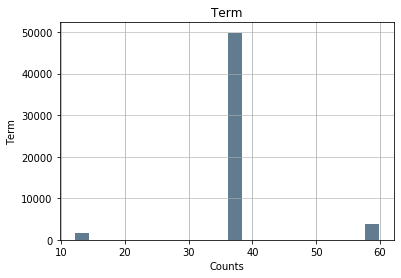

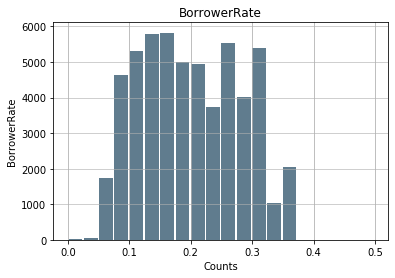

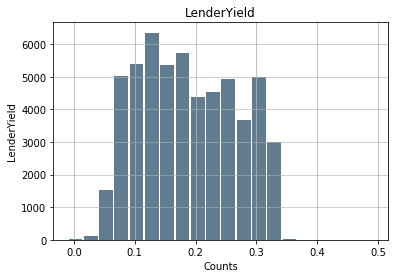

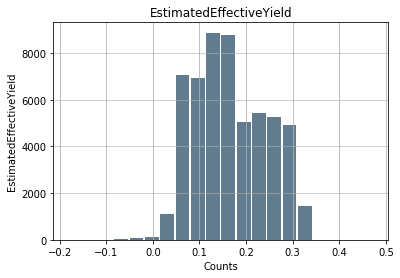

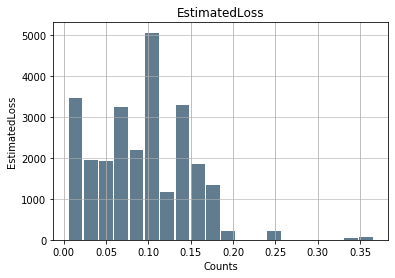

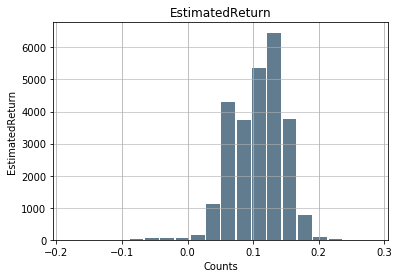

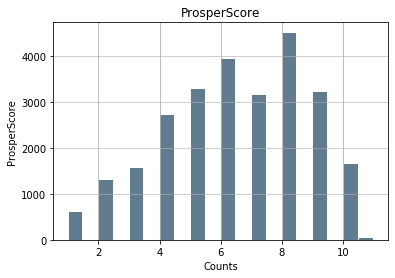

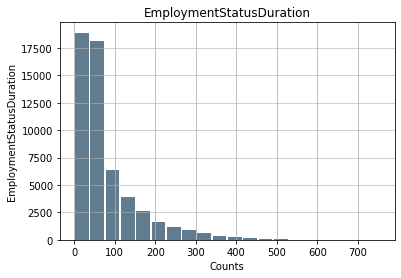

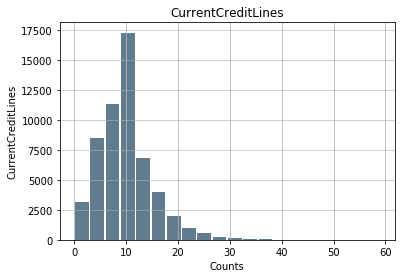

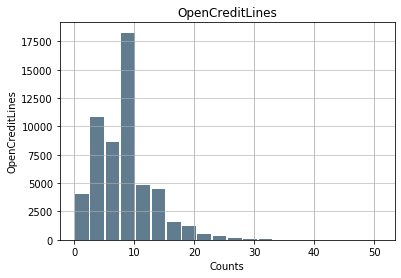

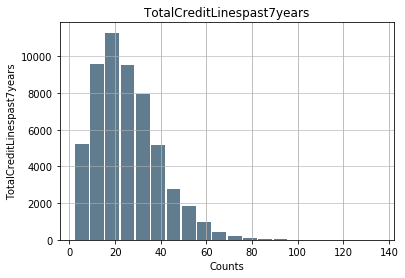

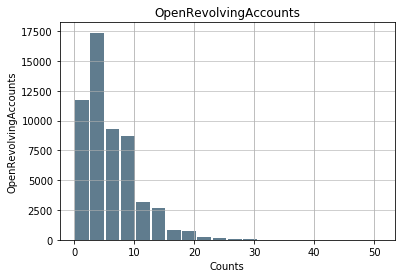

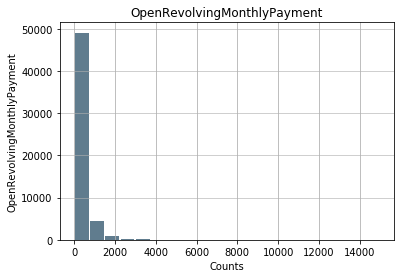

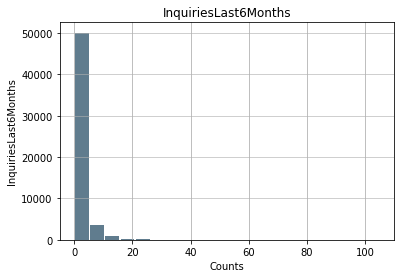

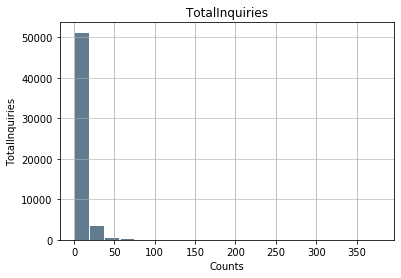

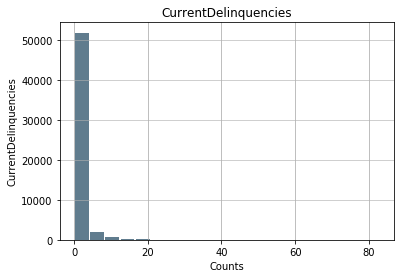

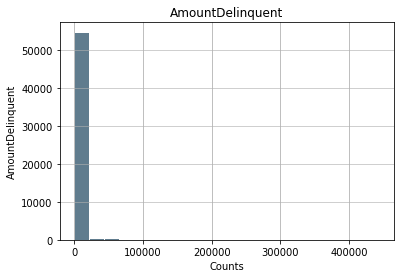

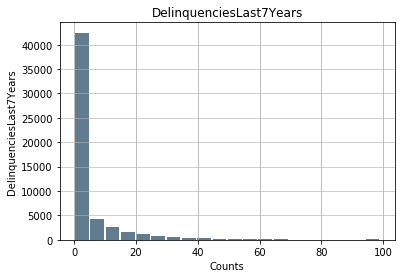

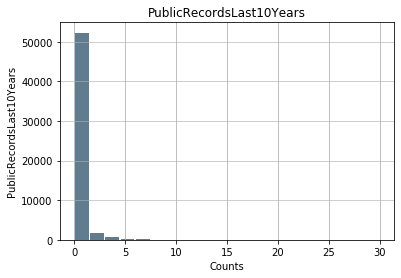

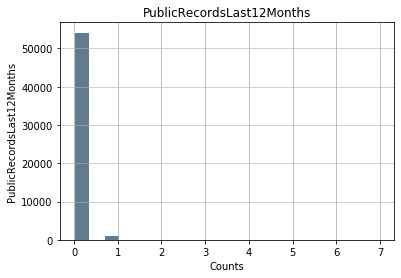

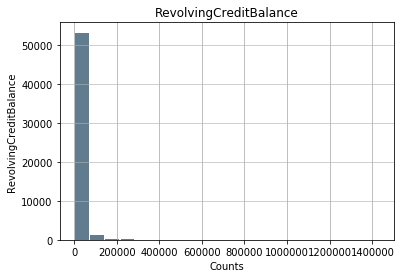

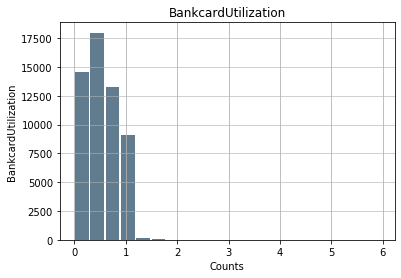

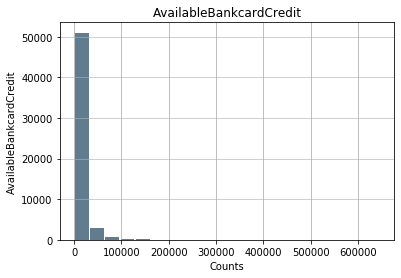

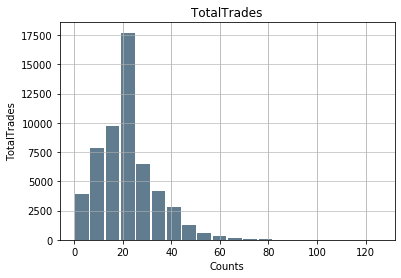

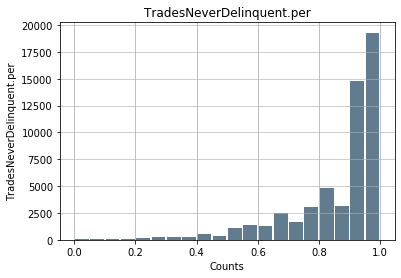

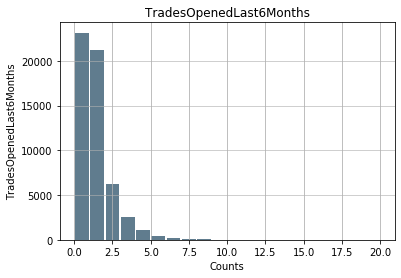

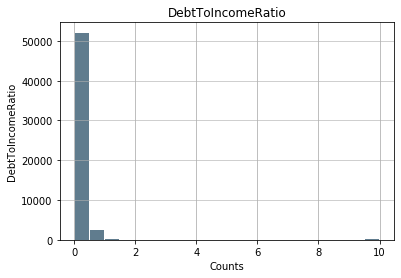

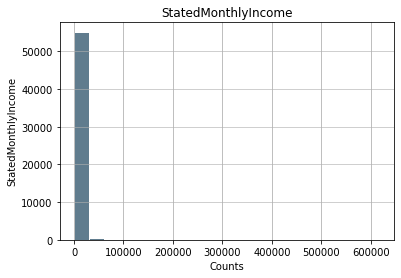

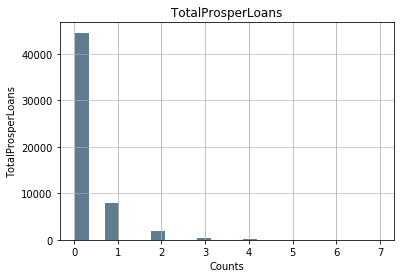

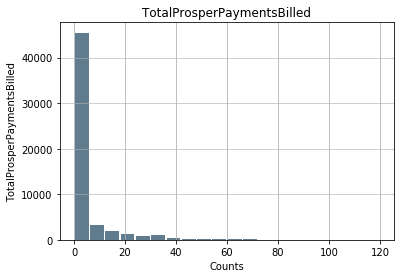

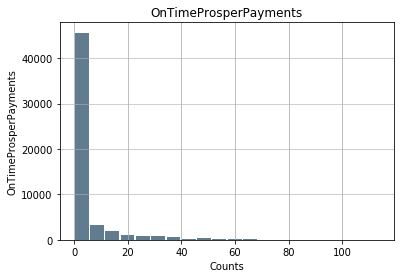

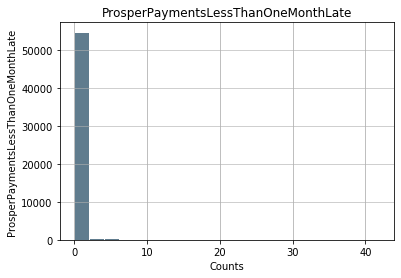

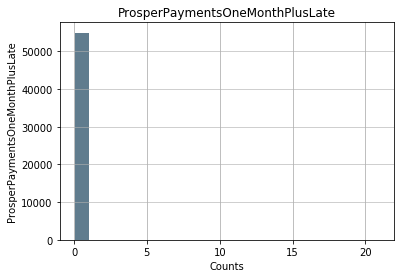

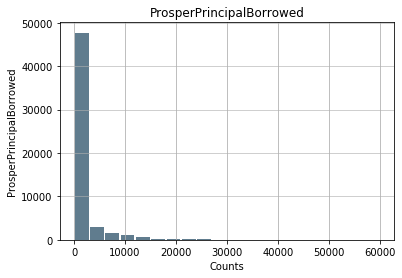

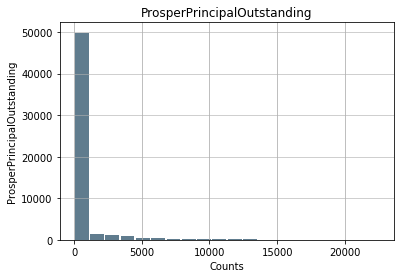

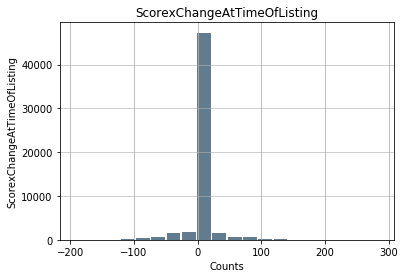

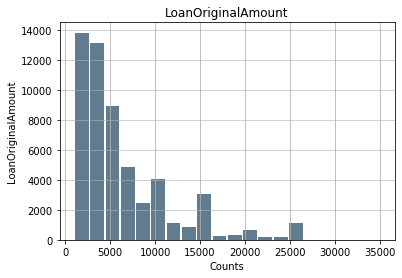

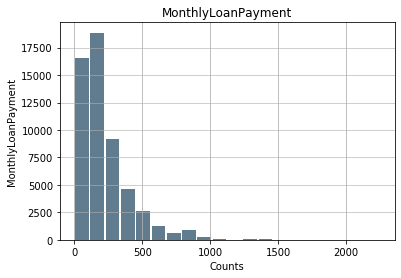

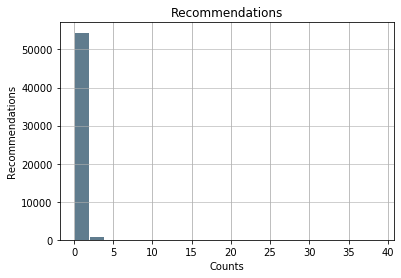

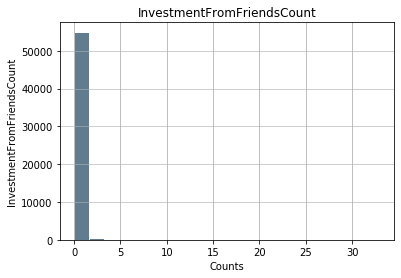

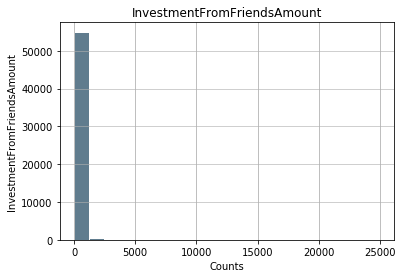

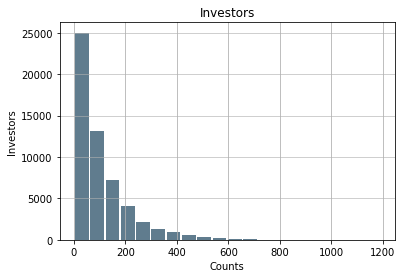

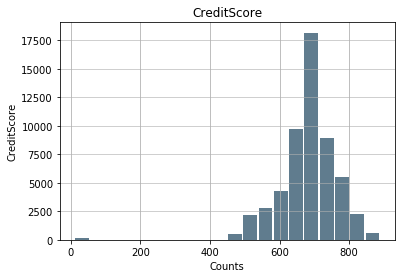

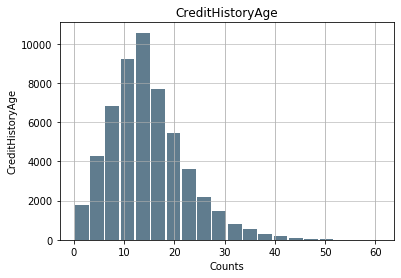

In [76]:
# Split the data into features and target label
completion = data["Completed.num"]
default = 1 - completion
features_raw = data.drop("Completed.num", axis = 1)

# Visualize continuous features of original data
continuous_features = ["Term", "BorrowerRate", "LenderYield", "EstimatedEffectiveYield", 
                       "EstimatedLoss", "EstimatedReturn", "ProsperScore", 
                       "EmploymentStatusDuration", "CurrentCreditLines", "OpenCreditLines", 
                       "TotalCreditLinespast7years", "OpenRevolvingAccounts", 
                       "OpenRevolvingMonthlyPayment", "InquiriesLast6Months", "TotalInquiries", 
                       "CurrentDelinquencies", "AmountDelinquent", "DelinquenciesLast7Years",
                       "PublicRecordsLast10Years", "PublicRecordsLast12Months", 
                       "RevolvingCreditBalance", "BankcardUtilization", "AvailableBankcardCredit", 
                       "TotalTrades", "TradesNeverDelinquent.per", "TradesOpenedLast6Months", 
                       "DebtToIncomeRatio", "StatedMonthlyIncome", "TotalProsperLoans", 
                       "TotalProsperPaymentsBilled", "OnTimeProsperPayments", 
                       "ProsperPaymentsLessThanOneMonthLate", "ProsperPaymentsOneMonthPlusLate", 
                       "ProsperPrincipalBorrowed", "ProsperPrincipalOutstanding", 
                       "ScorexChangeAtTimeOfListing", "LoanOriginalAmount", "MonthlyLoanPayment", 
                       "Recommendations", "InvestmentFromFriendsCount", "InvestmentFromFriendsAmount", 
                       "Investors", "CreditScore", "CreditHistoryAge"]

for feature in continuous_features:
    size, scale = 1000, 10
    data[feature].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
    plt.title(feature)
    plt.xlabel('Counts')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Below, I perform a log-transformation on those features I noted to be skewed, adding a small number to `x`, since the logarithm of 0 is undefined.

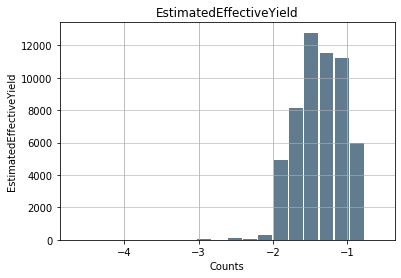

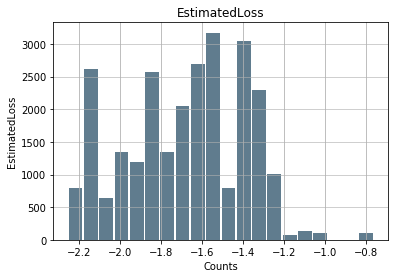

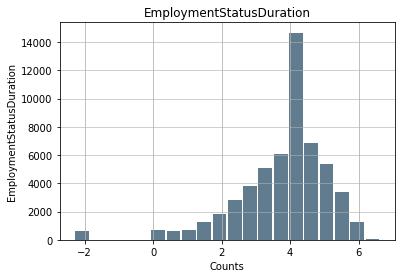

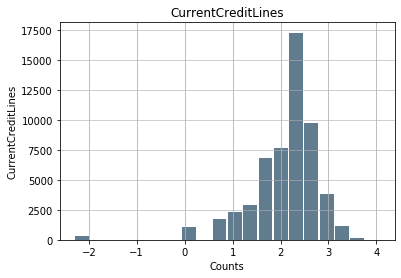

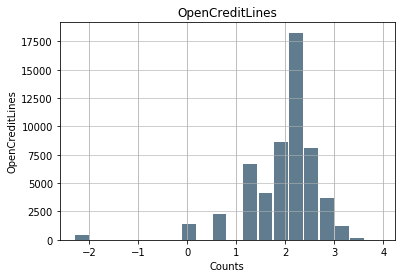

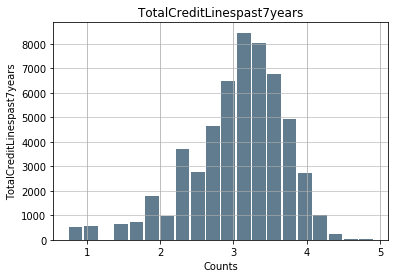

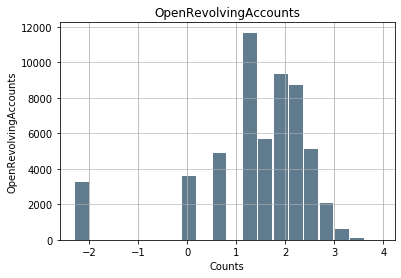

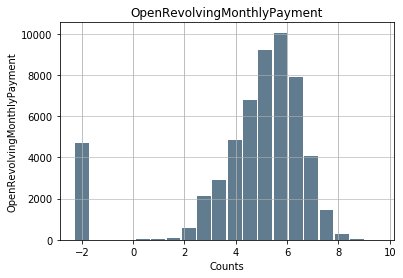

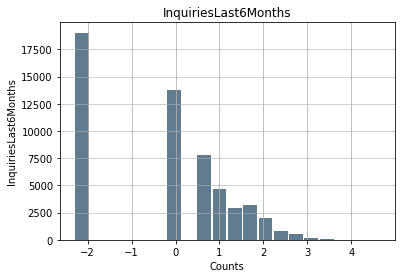

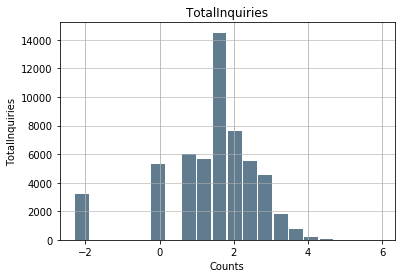

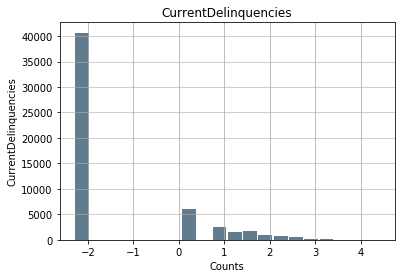

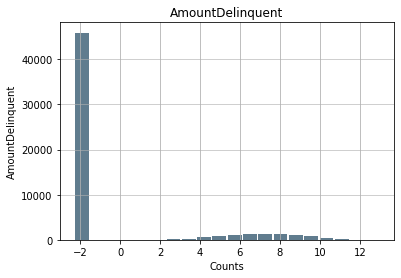

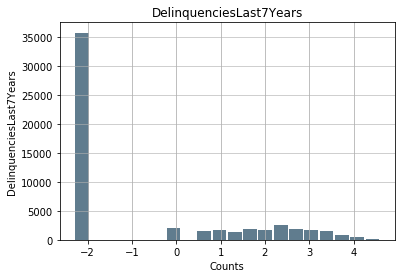

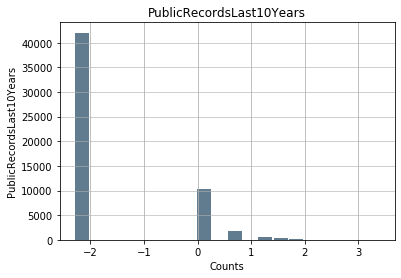

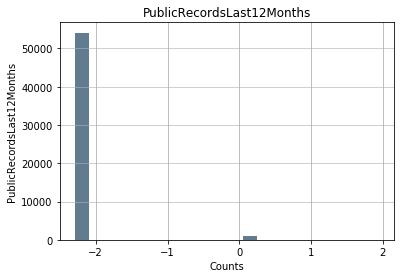

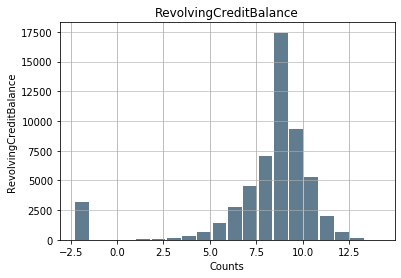

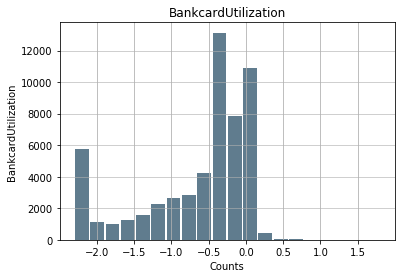

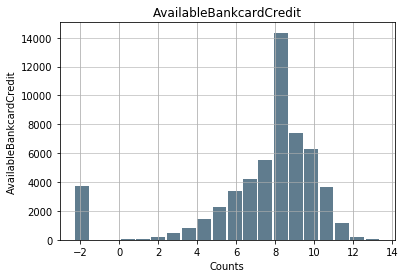

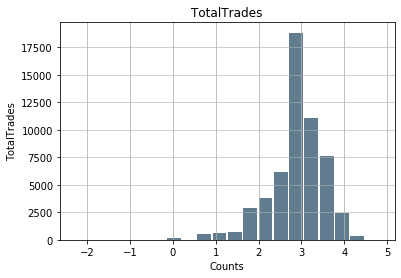

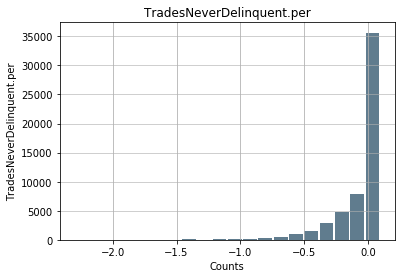

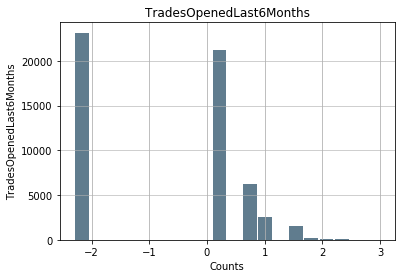

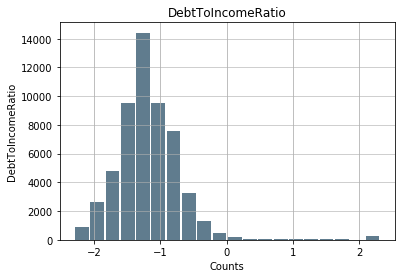

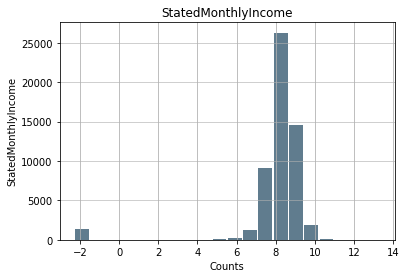

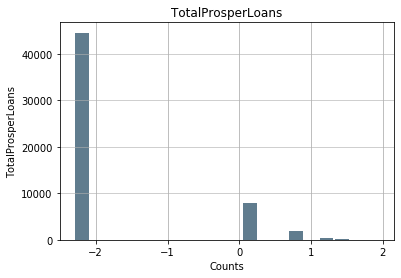

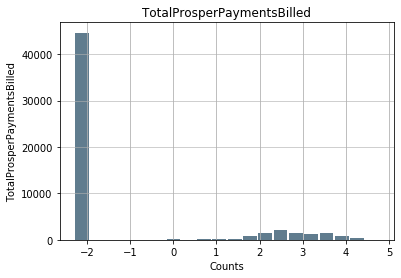

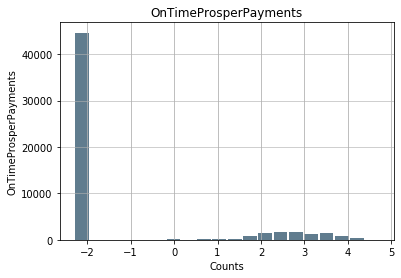

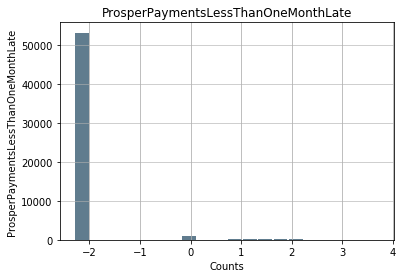

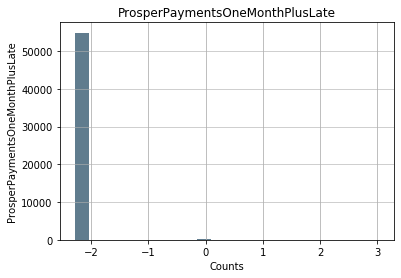

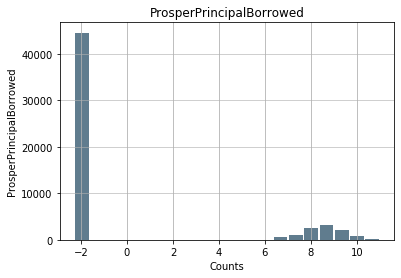

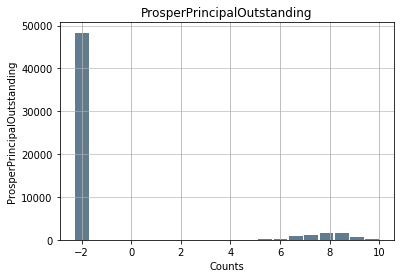

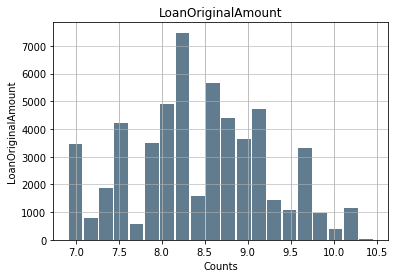

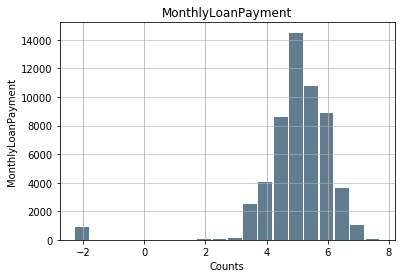

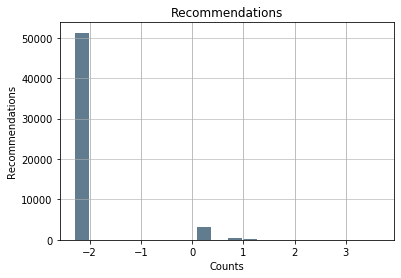

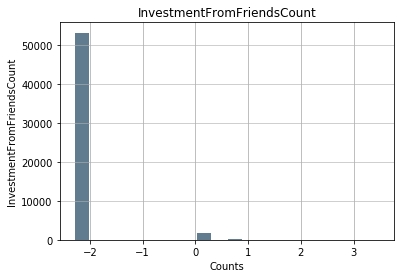

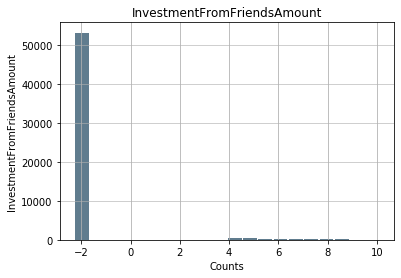

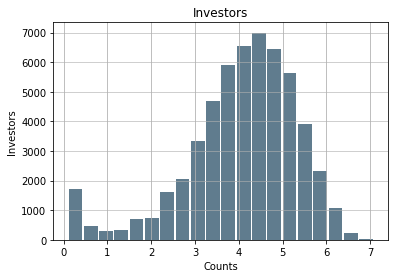

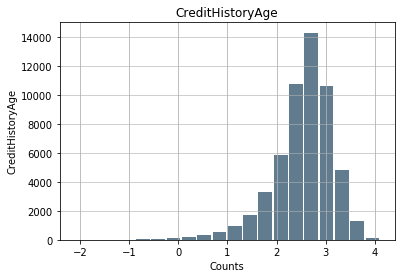

In [77]:
# Log-transform the skewed features
skewed = ['EstimatedEffectiveYield', 'EstimatedLoss', 'EmploymentStatusDuration', 
          'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 
          'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 
          'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 
          'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
          'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 
          'TotalTrades', 'TradesNeverDelinquent.per', 'TradesOpenedLast6Months', 
          'DebtToIncomeRatio', 'StatedMonthlyIncome', 'TotalProsperLoans', 
          'TotalProsperPaymentsBilled', 'OnTimeProsperPayments',
          'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 
          'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'LoanOriginalAmount', 
          'MonthlyLoanPayment', 'Recommendations', 'InvestmentFromFriendsCount', 
          'InvestmentFromFriendsAmount', 'Investors', 'CreditHistoryAge']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 0.1))

# Visualize the new log distributions
for feature in skewed:
    size, scale = 1000, 10
    features_log_transformed[feature].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
    plt.title(feature)
    plt.xlabel('Counts')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Many of the features are still not normally distributed, but their values are by and large less extreme, and less likely to affect learning algorithms.  In the future, I will explore other transformations that may be applied to non-normally-distributed features.

### Coding Categorical Data

Since many learning algorithms only take numerical input, below I dummy-code categorical variables, with `0` indicating the absence of a feature/feature category, and `1` indicating its presence.

In [78]:
features_log_transformed.sample(10)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,CreditScore,CreditHistoryAge
44923,1380758400000000000,36,0.2769,0.2669,-1.070200,-1.437588,0.10544,2.0,Debt,Employed,5.617135,False,1380758400000000000,1.131402,1.131402,3.468856,1.410987,5.118592,-2.302585,0.741937,-2.302585,-2.302585,2.949688,0.095310,-2.302585,8.601920,0.076961,4.683057,3.404525,-0.186330,-2.302585,-1.514128,True,8.374115,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,8.294075,1381363200000000000,5.105279,-2.302585,-2.302585,-2.302585,0.095310,E,649.5,2.703015
15515,1215648000000000000,36,0.0900,0.0800,-1.793361,NaN,NaN,NaN,Other,Full-time,3.222868,False,1215648000000000000,1.960095,1.808289,3.000720,1.629241,5.434159,-2.302585,0.741937,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9.598870,-0.385662,9.273512,2.949688,0.039221,-2.302585,-1.203973,False,8.138083,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,6.907855,1216598400000000000,3.462606,-2.302585,-2.302585,-2.302585,3.586293,A,729.5,2.298329
8696,1193875200000000000,36,0.1100,0.1000,-1.679860,NaN,NaN,NaN,Unknown,Full-time,3.299534,True,1193702400000000000,2.949688,2.646175,3.972177,2.091864,5.697429,1.629241,2.646175,-2.302585,-2.302585,3.666122,0.095310,-2.302585,8.800280,-0.673345,9.063822,3.666122,-0.342490,1.131402,-0.843970,True,8.138886,0.095310,2.493205,2.493205,-2.302585,-2.302585,6.907855,6.557077,80.0,6.907855,1194998400000000000,3.491647,-2.302585,-2.302585,-2.302585,4.096010,B,689.5,2.424560
21137,1362355200000000000,36,0.2786,0.2686,-1.065081,-1.458865,0.11220,4.0,Debt,Employed,4.949469,False,1362355200000000000,2.895912,2.895912,3.299534,2.714695,7.153912,1.410987,2.208274,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,10.582285,-0.415515,10.269453,3.299534,0.058269,0.741937,-0.798508,True,8.840486,0.095310,2.091864,2.091864,-2.302585,-2.302585,9.615812,-2.302585,-43.0,8.294075,1362528000000000000,5.107459,-2.302585,-2.302585,-2.302585,2.091864,E,629.5,2.792173
30124,1270944000000000000,36,0.0920,0.0820,-1.827594,-2.111965,0.06080,9.0,Debt,Full-time,4.719391,False,1270944000000000000,1.960095,1.960095,3.139833,1.808289,7.029176,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,11.027298,-0.051293,8.800129,2.949688,0.095310,-2.302585,-1.237874,True,9.104991,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,8.517213,1271894400000000000,5.072420,-2.302585,-2.302585,-2.302585,5.130490,A,709.5,3.101511
40523,1199836800000000000,36,0.0800,0.0800,-1.855338,NaN,NaN,NaN,Debt,Full-time,4.191169,True,1199836800000000000,2.312535,2.312535,3.404525,1.960095,6.794699,-2.302585,0.095310,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,11.574464,-0.462035,10.540940,3.299534,0.095310,-2.302585,-1.309333,True,8.804890,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,8.517213,1200528000000000000,5.054844,-2.302585,-2.302585,-2.302585,4.927978,AA,789.5,2.508931
34733,1340928000000000000,60,0.2610,0.2510,-1.064791,-1.614450,0.

Below, I dummy-code all categorical features:

In [79]:
# dummy-code the log-transformed features
features_final = pd.get_dummies(features_log_transformed)

# Print the number of features after dummy-coding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

88 total features after one-hot encoding.
['ListingCreationDate', 'Term', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperScore', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'DateCreditPulled', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent.per', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeVerifiable', 'StatedMonthlyIncome', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'ScorexChangeAtTimeOfListing

## Dimensionality Reduction

In this section, I use principal component analysis (PCA) to see if the features in my dataset can be reduced to fewer dimensions, which may improve algorithm performance, and reduce feature redundancy.

Below, I split the data into training and testing datasets.

In [80]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(features_final, completion, 
                                                    test_size=0.15, random_state=42)

### Normalizing Numerical Features

Prior to using PCA, I scale all numerical features, which ensures that algorithms treat features equally, rather than giving some undue weight.

In [81]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)

X_train_scaled = X_train
X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])

X_test_scaled = X_test
X_test_scaled[continuous_features] = scaler.fit_transform(X_test[continuous_features])

In [82]:
# Show the results of the split
print("Training set has {} samples.".format(X_train_scaled.shape[0]))
print("Testing set has {} samples.".format(X_test_scaled.shape[0]))

Training set has 46821 samples.
Testing set has 8263 samples.


Below, I drop all columns with remaining missing values, and save the data to a separate testing/training set which can be used with algorithms which handle missing data natively.

In [83]:
X_test_scaled.sample(10)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,CreditScore,CreditHistoryAge,ListingCategory_Auto,ListingCategory_Baby,ListingCategory_Boat,ListingCategory_Business,ListingCategory_Cosmetic,ListingCategory_Debt,ListingCategory_Engagement,ListingCategory_Green,ListingCategory_Household,ListingCategory_LargePurchase,ListingCategory_Medical,ListingCategory_Motorcycle,ListingCategory_Other,ListingCategory_Personal,ListingCategory_RV,ListingCategory_Reno,ListingCategory_Student,ListingCategory_Taxes,ListingCategory_Unknown,ListingCategory_Vacation,ListingCategory_Wedding,EmploymentStatus_Employed,EmploymentStatus_Full-time,EmploymentStatus_Not available,EmploymentStatus_Not employed,EmploymentStatus_Other,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed,EmploymentStatus_Unknown,Rating_A,Rating_AA,Rating_B,Rating_C,Rating_D,Rating_E,Rating_HR,Rating_NC,Rating_Unknown
45977,1319760000000000000,0.5,0.888611,0.876438,0.969110,0.621470,0.652347,0.2,0.899029,True,1319760000000000000,0.673439,0.672649,0.584089,0.667907,0.639895,0.344649,0.499190,0.000000,0.000000,0.000000,0.0,0.000000,0.647344,0.577736,0.485542,0.591105,0.897355,0.000000,0.300317,True,0.677548,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.445977,0.389908,1320364800000000000,0.744699,0.0,0.0,0.0,0.489904,0.795455,0.764085,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
48299,1179878400000000000,0.5,0.800000,0.761644,0.948459,NaN,NaN,NaN,0.747057,False,1178928000000000000,0.621169,0.672649,0.434602,0.557931,0.645238,0.565121,0.571885,0.538089,0.549972,0.538299,0.5,0.562532,0.641569,0.601588,0.000000,0.455207,0.545617,0.500000,0.271389,True,0.669072,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.445977,0.308992,1181001600000000000,0.711916,0.0,0.0,0.0,0.555437,0.590909,0.636161,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
35527,1295827200000000000,0.5,0.749722,0.739452,0.939698,0.459054,0.693756,0.5,0.850813,False,1295827200000000000,0.812305,0.831454,0.625373,0.815174,0.714138,0.437589,0.369701,0.000000,0.000000,0.000000,0.0,0.000000,0.686910,0.331732,0.801749,0.682203,0.968511,0.716042,0.277492,True,0.664357,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.445977,0.503952,1296432000000000000,0.778680,0.0,0.0,0.0,0.701931,0.727273,0.810983,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
53357,1348444800000000000,0.5,0.824722,0.813425,0.955740,0.575654,0.651461,0.4,0.751347,False,1347667200000000000,0.744034,0.755158,0.643696,0.692572,0.668827,0.437589,0.499190,0.375739,0.493052,0.441317,0.0,0.000000,0.519685,0.082014,0.722810,0.682203,0.968511,0.000000,0.271389,True,0.677635,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.445977,0.389908,1348704000000000000,0.741754,0.0,0.0,0.0,0.479254,0.863636,0.752809,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
53920,1184025600000000000,0.5,0.805556,0.794521,0.950024,NaN,NaN,NaN,0.658626,False,1184025600000000000,0.621169,0.607640,0.605

In [84]:
X_train_non_na = X_train_scaled.drop(['EstimatedEffectiveYield', 'EstimatedLoss',
                                      'EstimatedReturn', 'ProsperScore'], axis=1)
X_test_non_na = X_test_scaled.drop(['EstimatedEffectiveYield', 'EstimatedLoss',
                                    'EstimatedReturn', 'ProsperScore'], axis=1)

X_train_full = X_train_scaled
X_test_full = X_test_scaled

### Applying Dimensionality Reduction

Below, I reduce the features to 10 components, and then 3 components.  I further reduce the dataset to the top 30% of most important features (those that account for the most variance), and to the top 10%.  All are saved to separate testing/training sets.

In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=42)
pca.fit(X_train_non_na)

X_train_pca10 = pca.transform(X_train_non_na)
X_test_pca10 = pca.transform(X_test_non_na)

pca.explained_variance_ratio_

array([9.99553652e-01, 4.25776825e-04, 2.05712758e-05, 2.80739589e-35,
       2.24527096e-35, 1.80334345e-35, 1.50403059e-35, 1.47244440e-35,
       1.30543003e-35, 1.12248260e-35])

In [86]:
pca = PCA(n_components=3, random_state=42)
pca.fit(X_train_non_na)

X_train_pca3 = pca.transform(X_train_non_na)
X_test_pca3 = pca.transform(X_test_non_na)

pca.explained_variance_ratio_

array([9.99553652e-01, 4.25776825e-04, 2.05712758e-05])

In [87]:
from sklearn.feature_selection import SelectPercentile

X_train_reduce30 = SelectPercentile(percentile=30).fit_transform(X_train_non_na, 
                                                                 y_train)
X_test_reduce30 = SelectPercentile(percentile=30).fit_transform(X_test_non_na, 
                                                                y_test)

X_train_reduce10 = SelectPercentile(percentile=10).fit_transform(X_train_non_na, 
                                                                 y_train)
X_test_reduce10 = SelectPercentile(percentile=10).fit_transform(X_test_non_na, 
                                                                y_test)

Above, it looks like the most important three features account for quite a bit of the variance, and the rest account for comparatively tiny portions.  This may make the use of a highly reduced dataset feasible.

----
## Evaluating Model Performance


### The Naive Predictor

Below, we look at how a simple model, which always predicts that a loan is repaid, performs.  Although the accuracy and F-score in this case is rather high, it is clear that this model performs rather poorly.  An improved model must have higher precision -- which denotes how many of the loans identified as repaid were, in fact, repaid -- even if at the expense of recall, particularly given that lenders should be more wary of investing in loans unlikely to pay off, even if this involves risk of not investing in potentially high-yield loans.

In [88]:
# true positives
TP = np.sum(completion)
# false positives
FP = completion.count() - TP

# true negatives
TN = 0
# false negatives
FN = 0

# accuracy, precision and recall
accuracy = TP/(TP+FP)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# F-score for beta = 1
fscore = (1+1**2) * (precision * recall)/(1**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}]".format(accuracy, 
                         fscore, precision, recall))

Naive Predictor: [Accuracy score: 0.6912, F-score: 0.8174, Precision: 0.6912, Recall: 1.0000]


## Model Application


I picked three Ensemble methods commonly used for the task of classification - one averaging method (random forests), and two boosting methods.  I also picked Logistic Regression, as having an output of probabilities allows for more interpretability, and flexibility after the fact in setting thresholds for decisions.  I broadly retain some of my previous descriptions of these model types, where I have previously used them.

For strengths and weaknesses of the relevant models, I primarily consulted the following sources, keeping in mind that heuristics do not necessarily apply to each data set:

https://medium.com/@randylaosat/machine-learning-whats-inside-the-box-861f5c7e72a3

https://medium.com/@vijaya.beeravalli/comparison-of-machine-learning-classification-models-for-credit-card-default-data-c3cf805c9a5a

https://www.dummies.com/programming/big-data/data-science/machine-learning-dummies-cheat-sheet/

https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c

https://medium.com/@grohith327/gradient-boosting-and-xgboost-90862daa6c77

#### Ensemble Methods: Random Forest

The strengths of this model, which averages across multiple decision trees, are the following: it natively handles categorical variables; it is less prone to overfitting than a single decision tree -- therefore, it is more likely to select relevant features; and it frequently outperforms other methods on accuracy.  **These features make this model a good candidate for this problem, which has numerous categorical and continuous features.  Given that after one-hot conversion, there were 88 total features, a model which will automatically select the most important features is of particular importance.**  Additionally, it can handle imbalanced data, which applies to this dataset, and is a flexible algorithm that does not require a lot of parameter tuning.

The weaknesses of this model are that it doesn't tend to perform well with a bad set of features; it's not very transparent, and it's hard to interpret what's going on in the algorithm. Further, too many trees can slow down the algorithm.

#### Ensemble Methods: AdaBoost

AdaBoost is particularly well-suited for boosting the performance of decision trees on binary classification tasks.  It typically does not overfit despite excellent accuracy (although it is to date unclear exactly how), and frequently outperforms other methods.  **These features make it a good model to attempt for this problem, given that the algorithm can be used to boost the performance of classifiers that work well natively with categorical data, such as decision trees, and like random forests will automatically select those features that are most important.**  It additionally does not require variable transformation, and has relatively few parameters that need tweaking.

The weaknesses of this model are that it does not deal well with noisy data, and the efficiency of the algorithm is affected by outliers, since the algorithm attempts to fit each point.

#### Logistic Regression

The strengths of this model are that it's fairly easy to interpret in terms of probabilities; relatively unlikely to overfit; fast; well-suited for binary classification tasks; and explanatory variables can be continuous or categorical.  **These features, and in particular the fact that results are probabilities, make this model a good candidate for this problem, since probabilities allow for post-hoc adjustment of the threshold for whether a lender should fund a particular loan, perhaps depending on their personal finances or risk aversion.**

The downsides of this model are that it's not particularly good at capturing complex or non-linear relationships between features, or dealing with multiple/non-linear decision boundaries; generally, it's not very flexible.

#### Ensemble Methods: XGBoost

XGBoost, recommended by a reviewer, is highly robust to irregularities in data, and like AdaBoost, is a boosting algorithm which tries to create a strong classifier from a series of weaker classifiers.  It additionally natively handles missing data.  **Given that the dataset I have is quite noisy, with quite a bit of missing or imputed data, and is particularly suited to decision trees, this algorithm would be appropriate to try.**

### Training and Predicting Pipeline

Below I use a training function adapted from another Udacity project to evaluate the peformance of the various classifiers, with repect to time and various metrics, on testing and training data.

In [89]:
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, precision_score, recall_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = f1_score(y_train[:300], predictions_train[:300])
        
    results['f_test'] = f1_score(y_test, predictions_test)
    
    results['p_train'] = precision_score(y_train[:300], predictions_train[:300])
        
    results['p_test'] = precision_score(y_test, predictions_test)
    
    results['r_train'] = recall_score(y_train[:300], predictions_train[:300])
        
    results['r_test'] = recall_score(y_test, predictions_test)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Model Evaluation


#### Full dataset without missing data

In [90]:
from time import time

clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_non_na = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_non_na[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_non_na[clf_name][i] = \
        train_predict(clf, samples, X_train_non_na, y_train, X_test_non_na, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


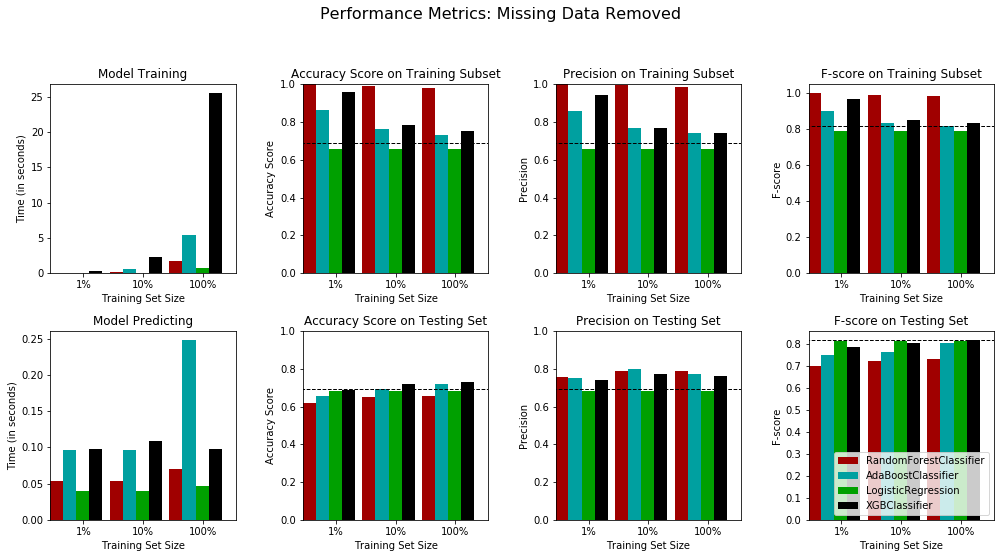

In [91]:
vs.evaluate(results_non_na, accuracy, 
            precision, fscore, "Performance Metrics: Missing Data Removed")

#### PCA: 10 most important features

In [92]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_pca10 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_pca10[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_pca10[clf_name][i] = \
        train_predict(clf, samples, X_train_pca10, y_train, X_test_pca10, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


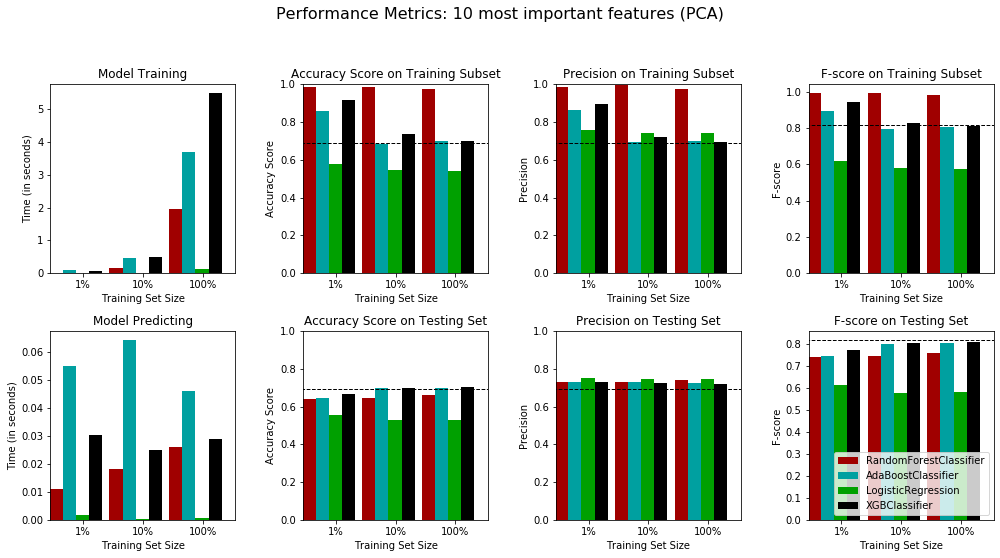

In [93]:
vs.evaluate(results_pca10, accuracy, 
            precision, fscore, "Performance Metrics: 10 most important features (PCA)")

#### PCA: 3 most important features

In [94]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_pca3 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_pca3[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_pca3[clf_name][i] = \
        train_predict(clf, samples, X_train_pca3, y_train, X_test_pca3, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


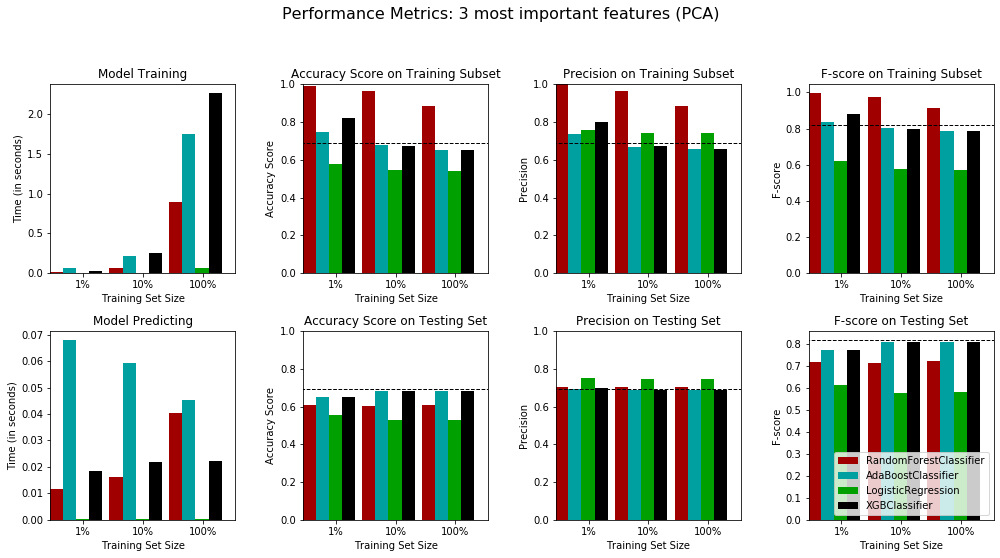

In [95]:
vs.evaluate(results_pca3, accuracy, 
            precision, fscore, "Performance Metrics: 3 most important features (PCA)")

#### PCA: top 30% of features

In [96]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_reduce30 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_reduce30[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_reduce30[clf_name][i] = \
        train_predict(clf, samples, X_train_reduce30, y_train, X_test_reduce30, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


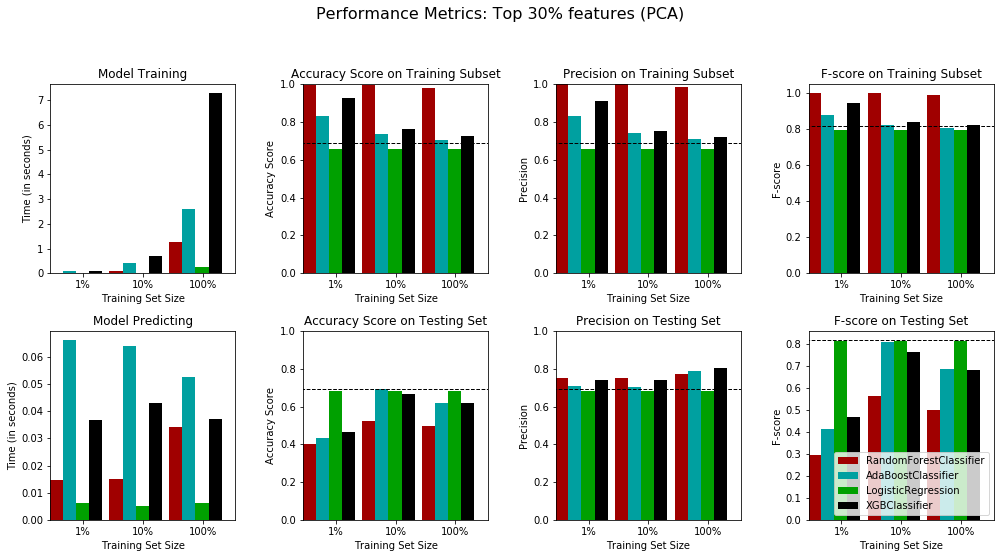

In [97]:
vs.evaluate(results_reduce30, accuracy, 
            precision, fscore, "Performance Metrics: Top 30% features (PCA)")

#### PCA: top 10% of features

In [98]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_reduce10 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_reduce10[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_reduce10[clf_name][i] = \
        train_predict(clf, samples, X_train_reduce10, y_train, X_test_reduce10, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


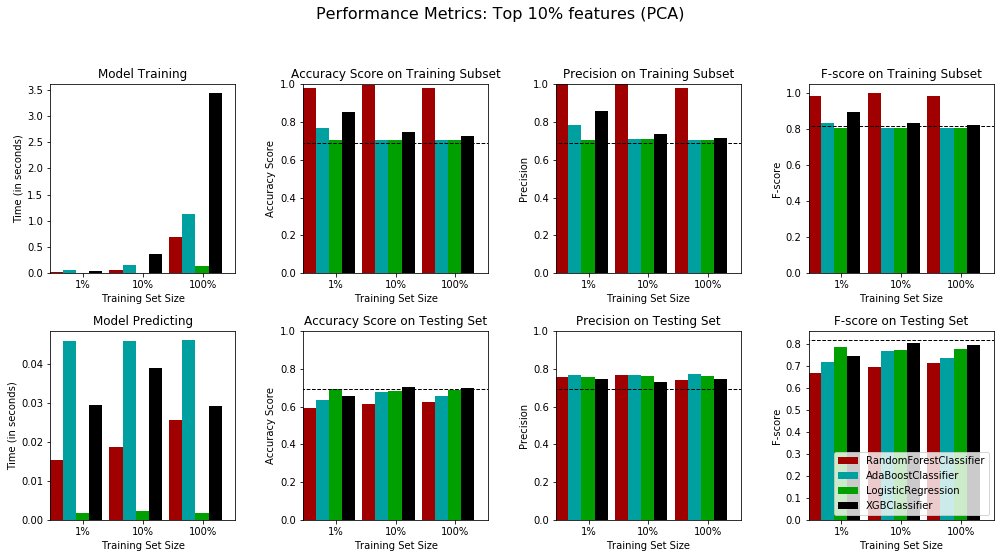

In [99]:
vs.evaluate(results_reduce10, accuracy, 
            precision, fscore, "Performance Metrics: Top 10% features (PCA)")

#### Full dataset with missing data (XGBoost only, which unlike AdaBoost handles missing values)

In [100]:
clf_A = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_full = {}
for clf in [clf_A]:
    clf_name = clf.__class__.__name__
    results_full[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_full[clf_name][i] = \
        train_predict(clf, samples, X_train_full, y_train, X_test_full, y_test)

XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


In [101]:
results_spliced = results_non_na
results_spliced["XGBClassifier_full"] = results_full["XGBClassifier"]

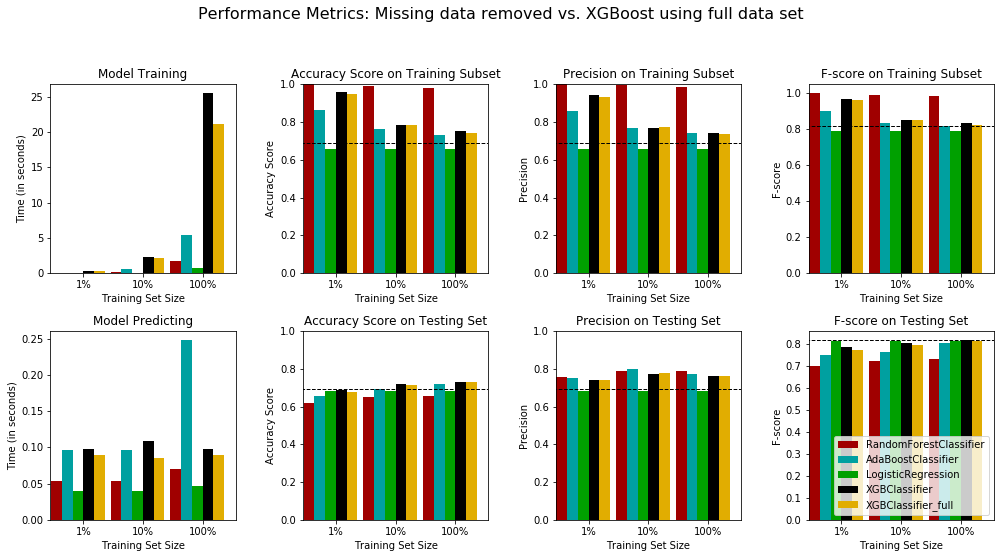

In [102]:
vs.evaluate5(results_spliced, accuracy, 
             precision, fscore, "Performance Metrics: Missing data removed vs. XGBoost using full data set")

----
## Optimizing Results

**As can be seen, the Random Forest model tends to overfit the training data, and then perform similar to other models on precision in testing, or underperform significantly on other measures.  It therefore appears comparatively unsuited to this task.  Logistic Regression tends to perform similarly to other models or underperform on precision, and performs moderately to significantly worse on other measures.  It rarely performs better than the naive classifier, and when it does, its performance is similar to that of other methods.  It therefore appears similarly unsuited, and its performance suffers significantly when the features are reduced to several dimensions.  In contrast, the boosting methods have a less pronounced tendency to overfit the data than the Random Forest method, show similar performance on precision, and higher performance on other measures (accuracy and f-score).  Although they are slower to train, they appear to be roughly comparable in testing, with XGBoost having an edge over AdaBoost.**

**AdaBoost and XGBoost perform roughly similarly on the testing and training data, with XGBoost perhaps having a slight edge in testing (no improvement on measures is seen from including the variables with missing data, in the latter case).  Performance appears to be best all-around (precision higher than naive; F1 metric no lower than naive) when all available features are used.  Both algorithms are similarly well-suited for the large number of continuous and categorical variables, as seen in this dataset, given that ensemble methods will pick out the most important features, and decision tree-based classifiers are paticularly well-suited to categorical data.  It is difficult to choose between the two methods based on the above results; I will therefore attempt to optimize both models.  Below, I briefly discuss how the two methods work.**

### AdaBoost

**AdaBoost takes a family of weak classifiers, which may perform only slightly better than chance at correctly classifying any given point, combines them, and lets them 'vote' on the correct category of any given point.  When a large number of such weak classifiers vote on any given point, the chance that this point will be correctly classified increases significantly.  By default, AdaBoost uses decision tree classifiers to classify points, although it can use different base classifiers.  The process of classifying points continues either until each point is correctly classified in a labeled data set, or until the maximum number of iterations specified is reached.**

**The image below illustrates this: a weak classifier in Box 1 classifies several of the positive points correctly, but misclassifies the rest of the positive points.  The weights of the misclassified samples are then increased, and the next weak classifier (Box 2) is more likely to classify these points correctly.  The weights of misclassified samples is increased again, and the process repeats.  In the end, the weak classifiers are combined, and 'vote' on the category a given point belongs to:**

![Boosting](boosting.png)

**The drawback of this method, as mentioned, is that it does not deal well with noisy data, given that it attempts to categorize all points correctly.  It is not, however, prone to overfitting, although the reason for this is not clear.**

Resources:

https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c (image copied from this resource)

### XGBoost

**XGBoost is a gradient boosting algorithm, which like AdaBoost attempts to create a strong learner from a group of weak learners, giving increased weight to previously misclassified outcomes, and lower weight to correctly classified outcomes.  Where it differs is that in gradient boosting, new learners work to reduce the residuals of previous learners, thus minimizing loss.  It further penalizes excessive complexity in decision trees, and has a randomization parameter which can reduce the correlation between trees.**

**The process of iteratively reducing residuals can be thus visualized, with error virtually eliminated by the 20th iteration:**

![XGB1](xgb1.png)

![XGB2](xgb2.png)

![XGB3](xgb3.png)

Resources:

https://hackernoon.com/gradient-boosting-and-xgboost-90862daa6c77 (remaining images copied from this source)
https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
https://www.datacamp.com/community/tutorials/xgboost-in-python
https://medium.com/syncedreview/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition-ca8034c0b283

### Model Tuning (AdaBoost)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = AdaBoostClassifier(random_state=42)

parameters = dict(n_estimators=[10, 50, 100, 500, 1000], 
                  learning_rate=[0.01, 0.1, 0.5, 1],
                  algorithm=['SAMME', 'SAMME.R'])

scorer = {'F1': make_scorer(f1_score), 
          'Precision': make_scorer(precision_score), 
          'Recall': make_scorer(recall_score)}

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer, refit='Precision')

grid_fit = grid_obj.fit(X_train_non_na, y_train)

best_adaboost_clf = grid_fit.best_estimator_

adaboost_predictions = (clf.fit(X_train_non_na, y_train)).predict(X_test_non_na)
best_adaboost_predictions = best_adaboost_clf.predict(X_test_non_na)

In [103]:
# dill.load_session('notebook_env1.db')

In [104]:
best_adaboost_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1,
 'n_estimators': 1000,
 'random_state': 42}

In [105]:
print("Unoptimized Model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, adaboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, adaboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, adaboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, adaboost_predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_adaboost_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_adaboost_predictions)))
print("Final precision on the testing data: {:.4f}".format(precision_score(y_test, best_adaboost_predictions)))
print("Final recall on the testing data: {:.4f}".format(recall_score(y_test, best_adaboost_predictions)))

Unoptimized Model
------
Accuracy score on testing data: 0.7217
F-score on testing data: 0.8051
Precision on testing data: 0.7725
Recall on testing data: 0.8406

Optimized Model
------
Final accuracy score on the testing data: 0.6898
Final F-score on the testing data: 0.7609
Final precision on the testing data: 0.8047
Final recall on the testing data: 0.7217


### Model Tuning (XGBoost)

In [ ]:
clf = XGBClassifier(random_state=42)

parameters = dict(n_estimators=[10, 50, 100, 500, 1000], 
                  learning_rate=[0.01, 0.1, 0.5, 1], 
                  max_depth=[3,6,9])

scorer = {'F1': make_scorer(f1_score), 
          'Precision': make_scorer(precision_score), 
          'Recall': make_scorer(recall_score)}

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer, refit='Precision')

grid_fit = grid_obj.fit(X_train_non_na, y_train)

best_xgboost_clf = grid_fit.best_estimator_

xgboost_predictions = (clf.fit(X_train_non_na, y_train)).predict(X_test_non_na)
best_xgboost_predictions = best_xgboost_clf.predict(X_test_non_na)

In [106]:
dill.load_session("notebook_env2.db")

In [107]:
best_xgboost_clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 1000,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1}

In [108]:
print("Unoptimized Model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, xgboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, xgboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, xgboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, xgboost_predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_xgboost_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_xgboost_predictions)))
print("Final precision on the testing data: {:.4f}".format(precision_score(y_test, best_xgboost_predictions)))
print("Final recall on the testing data: {:.4f}".format(recall_score(y_test, best_xgboost_predictions)))

Unoptimized Model
------
Accuracy score on testing data: 0.7315
F-score on testing data: 0.8180
Precision on testing data: 0.7626
Recall on testing data: 0.8820

Optimized Model
------
Final accuracy score on the testing data: 0.7264
Final F-score on the testing data: 0.7990
Final precision on the testing data: 0.8030
Final recall on the testing data: 0.7949


### Final Model Evaluation



#### Results:

|     Metric     | Naive Predictor   | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.6912            | 0.7217            |   0.6898        |
| F-score        | 0.8174            | 0.8051            |   0.7609        |
| Precision      | 0.6912            | 0.7725            |   0.8047        |
| Recall         | 1.0000            | 0.8406            |   0.7217        |

**Here it can be seen that although accuracy and recall are lower in the optimized model than in the unoptimized model, or the naive predictor, precision is higher, which should assist lenders in avoiding those loans most likely to default.**

----
## Feature Importance

### Extracting Feature Importance

Below, I plot the most important features for the optimal model chosen above.  As can be seen, the magnitude of the monthly loan payment, the age of credit history, the available bankcard credit, the stated monthly income, and employment status duration are the best predictors of whether a loan will default, or not.  Three of these predictors tend to correlate with a borrower's credit worthiness, and it is unsurprising that they primarily determine whether a loan will be paid back, or not.  Monthly income and empolyment status duration are, similarly, determinants of ability to pay back the loan.

In [111]:
model = best_xgboost_clf.fit(X_train_non_na, y_train)

importances_xgboost = best_xgboost_clf.feature_importances_

[12:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:07:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[12:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[12:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[12:08:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:08:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[12:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:09:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:09:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:09:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:09:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:09:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:09:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:09:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:09:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:09:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_dep

[12:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_d

[12:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_de

[12:10:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:10:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_de

[12:10:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:10:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[12:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_de

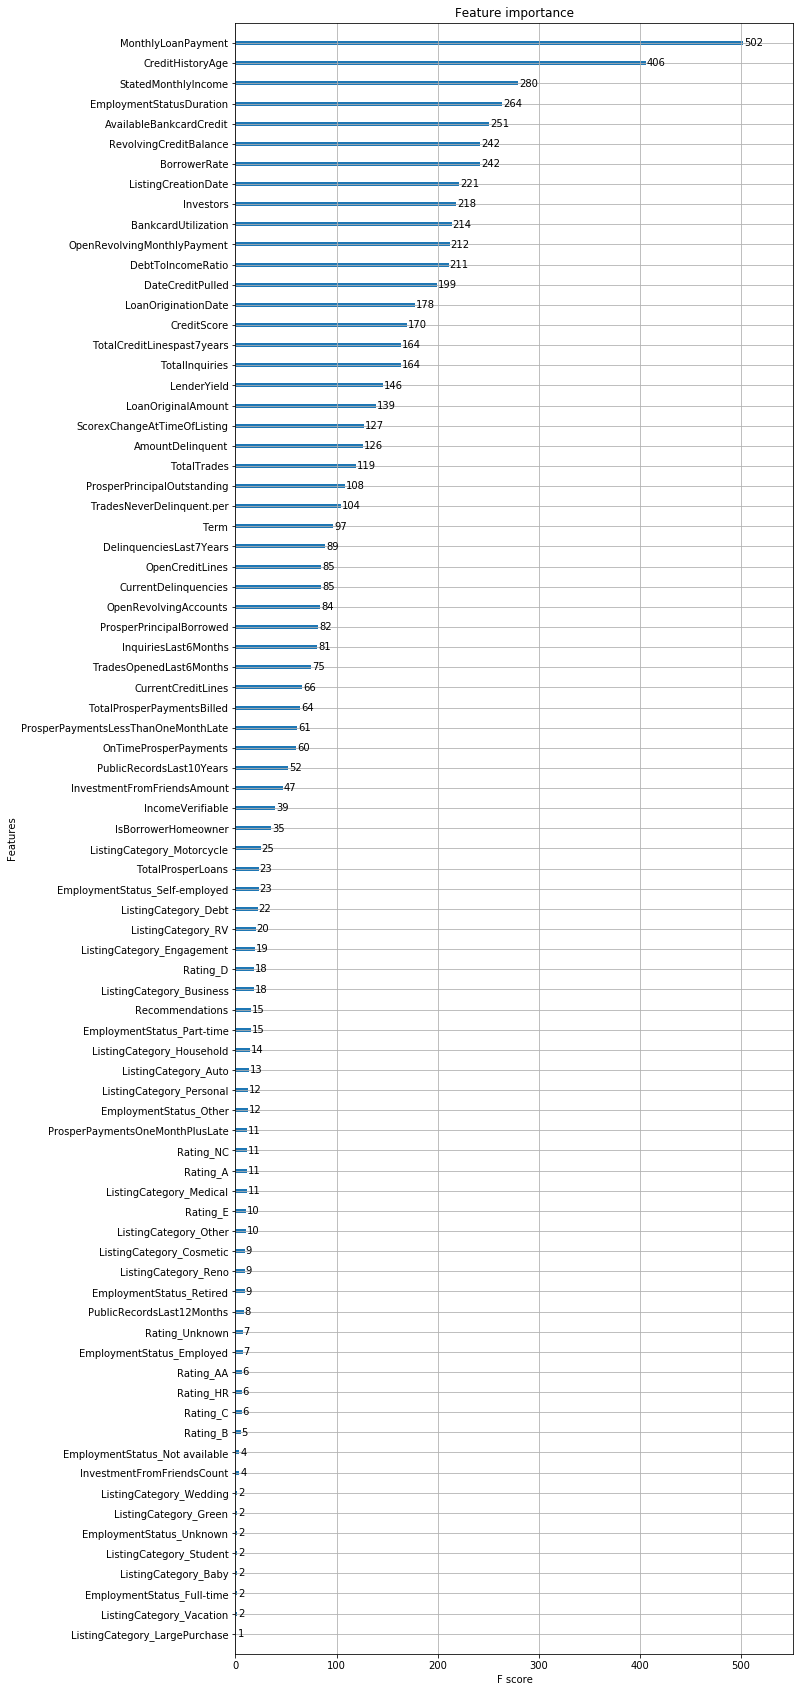

In [127]:
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (10, 30)
plot_importance(model)

### Feature Selection

Here, I look at how a model performs if only the five most important features are used.  Accuracy, f-score, and recall suffer, but precision, here arguably the most important metric, suffers only marginally.  With further exploration, it is possible that a model utilising only the most important features would show adequate performance in production.

In [129]:
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train_non_na[X_train_non_na.columns.values[(np.argsort(importances_xgboost)[::-1])[:5]]]
X_test_reduced = X_test_non_na[X_test_non_na.columns.values[(np.argsort(importances_xgboost)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
xgboost_clf = (clone(best_xgboost_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_xgboost_predictions = xgboost_clf.predict(X_test_reduced)

[12:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[12:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_d

[12:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_

[12:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[12:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[12:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[12:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[12:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[12:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[12:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_d

In [130]:
# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_xgboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, best_xgboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, best_xgboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, best_xgboost_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_xgboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, reduced_xgboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, reduced_xgboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, reduced_xgboost_predictions)))

Final Model trained on full data
------
Accuracy on testing data: 0.7264
F-score on testing data: 0.7990
Precision on testing data: 0.8030
Recall on testing data: 0.7949

Final Model trained on reduced data
------
Accuracy on testing data: 0.6853
F-score on testing data: 0.8056
Precision on testing data: 0.6976
Recall on testing data: 0.9533


In [139]:
dill.load_session('notebook_env3.db')

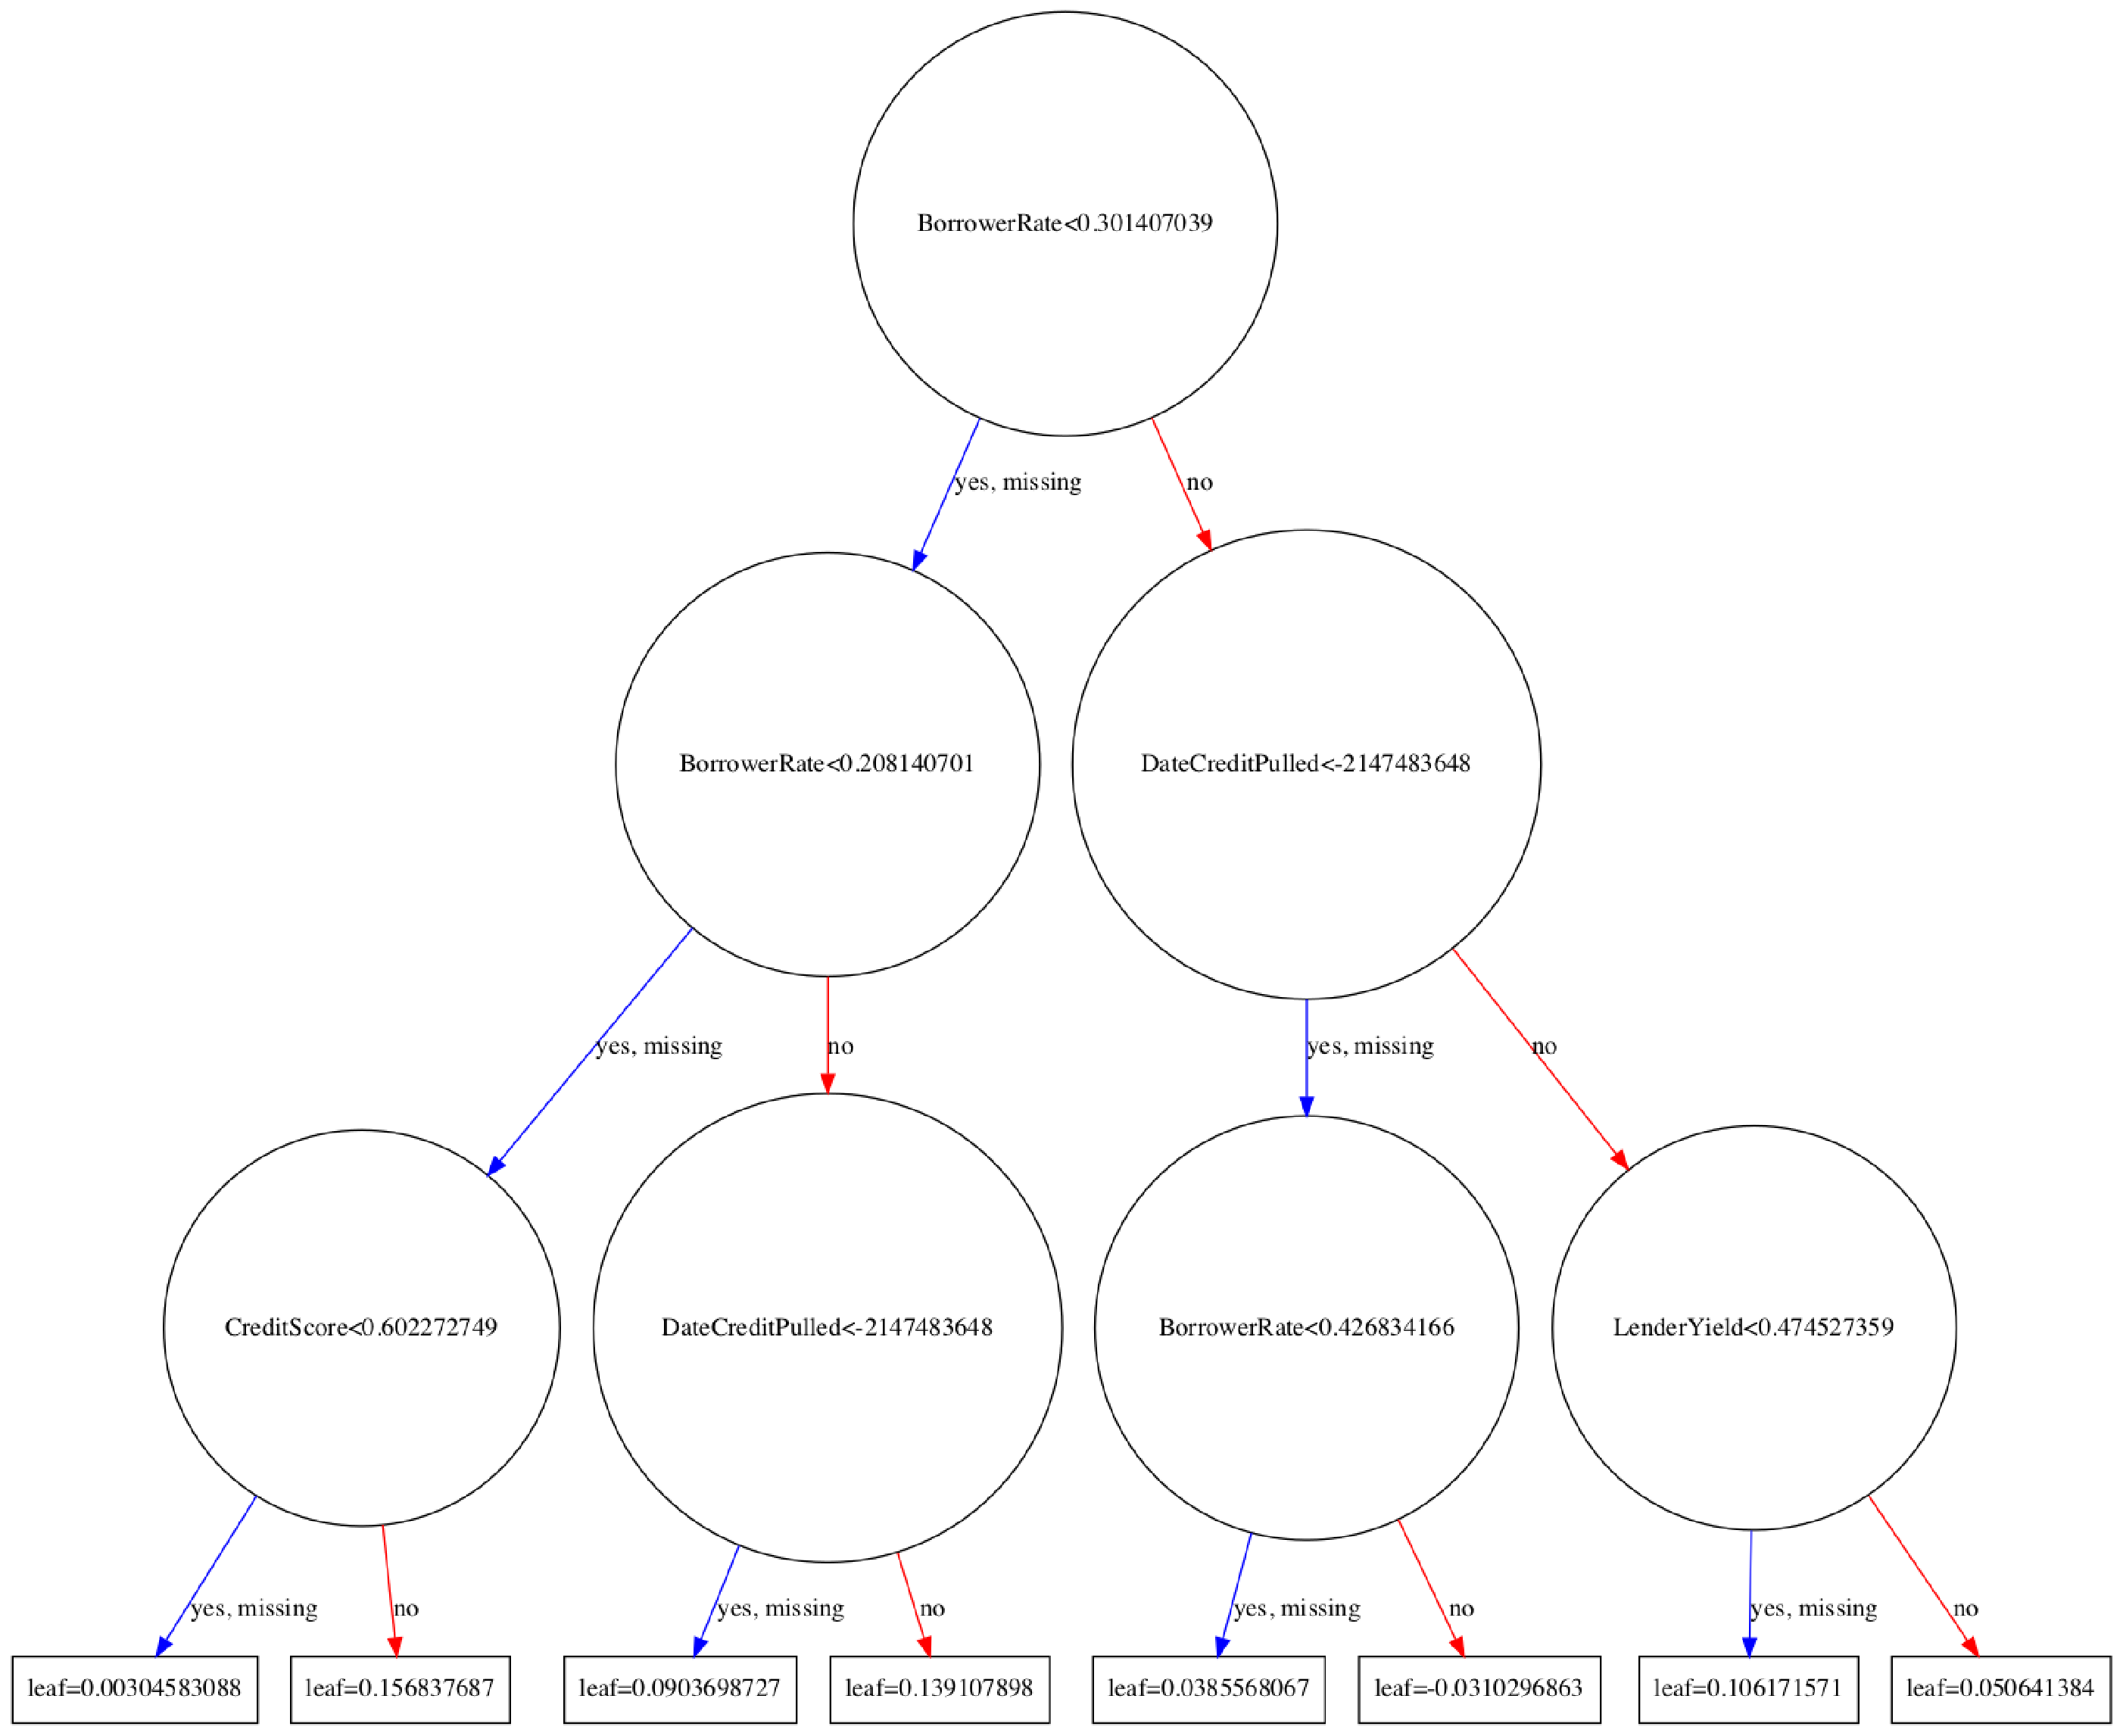

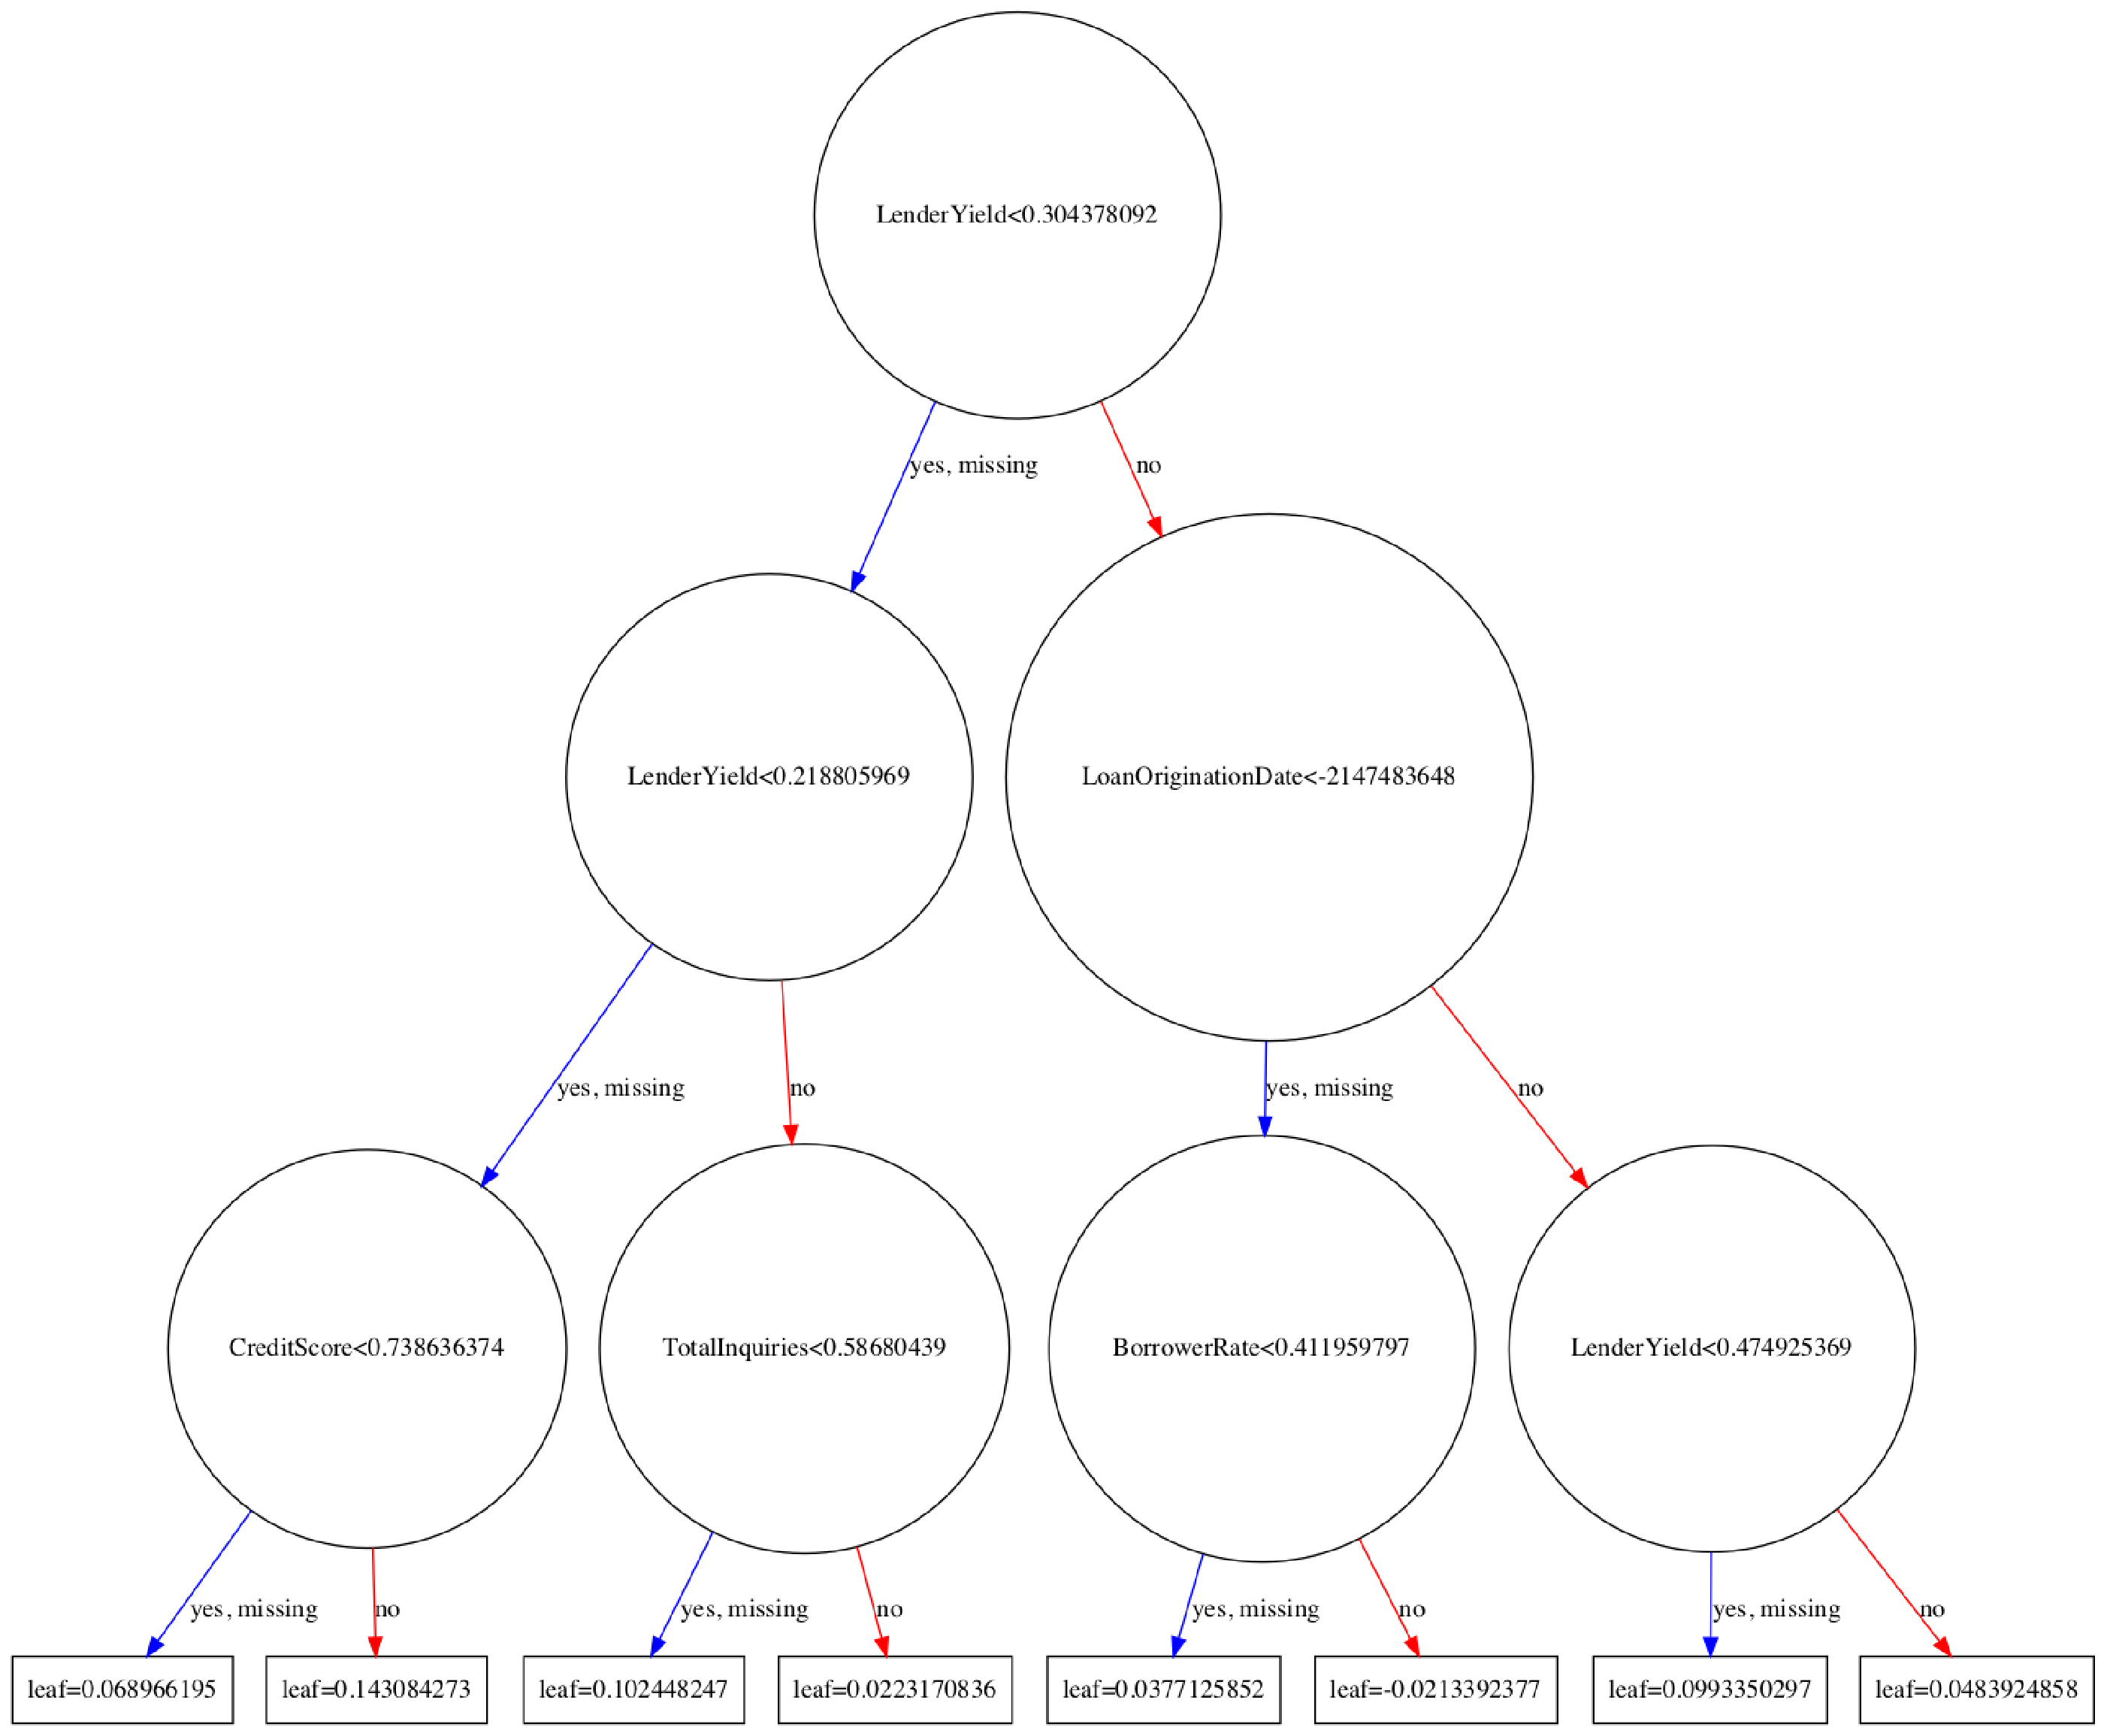

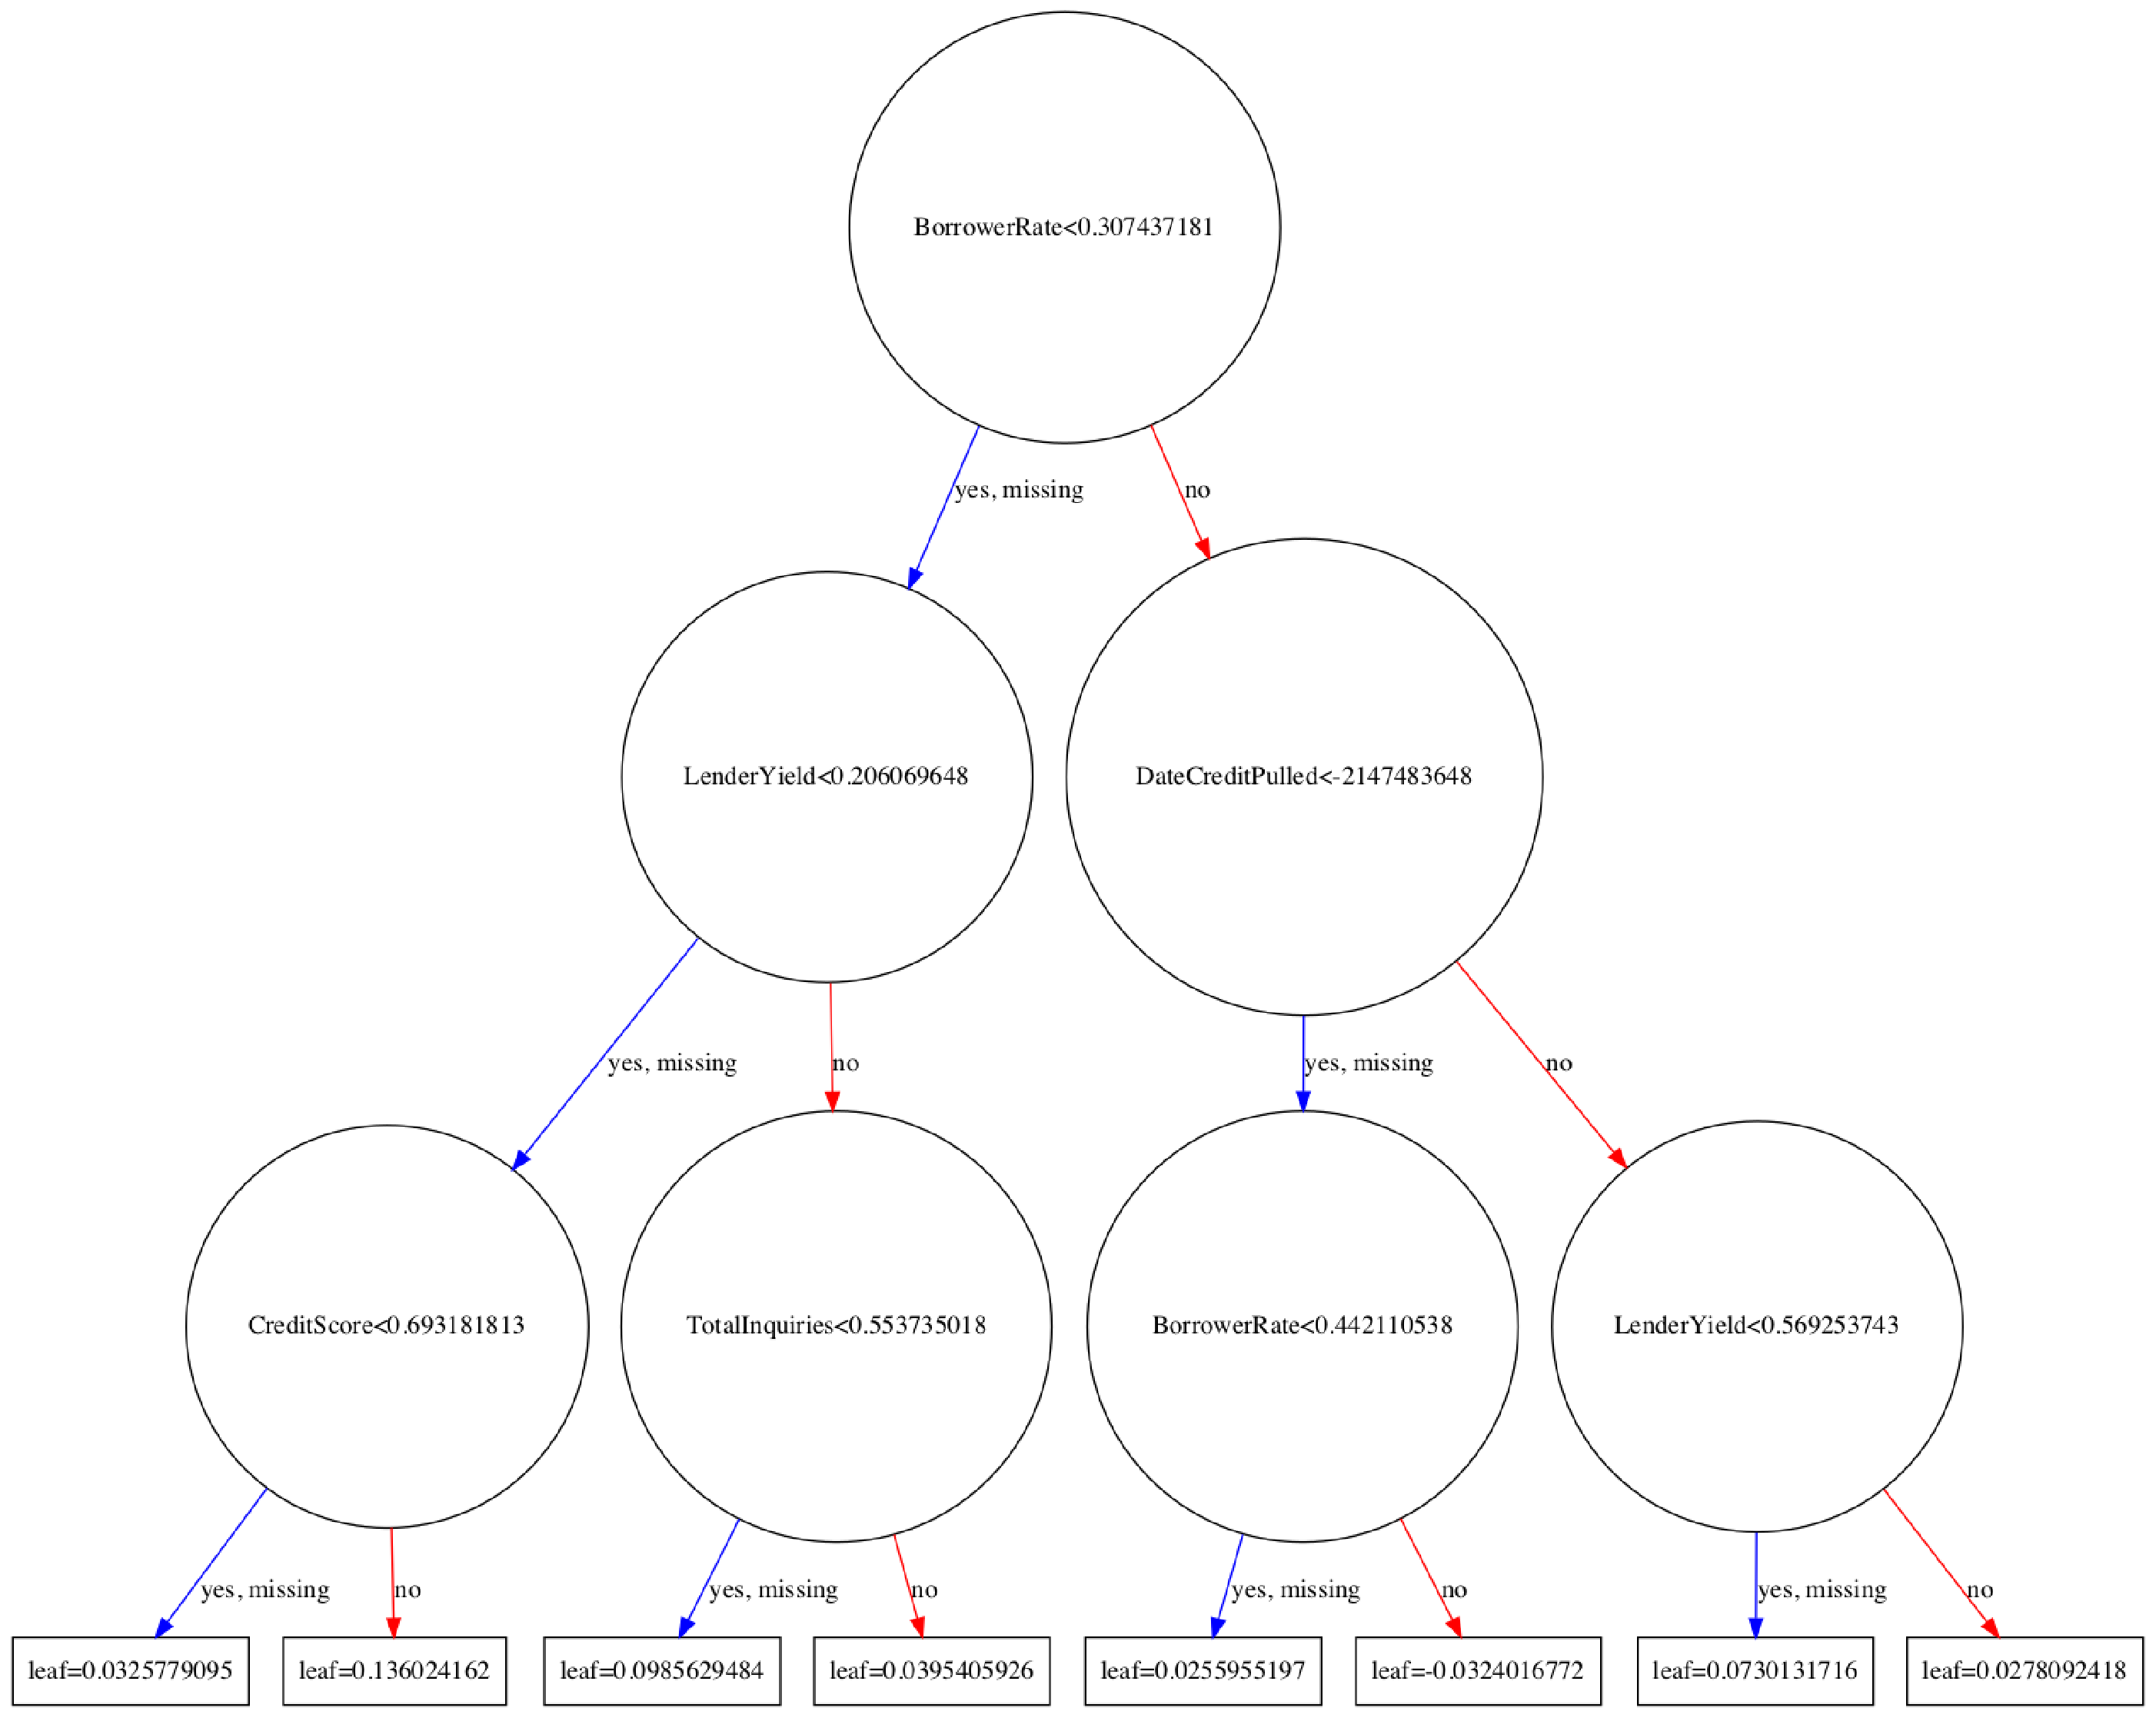

In [145]:
from xgboost import plot_tree

plt.rcParams["figure.figsize"] = (50, 50)
plot_tree(best_xgboost_clf, num_trees=1)
plot_tree(best_xgboost_clf, num_trees=2)
plot_tree(best_xgboost_clf, num_trees=3)
plt.show()

### Profit

Here, I look at projected profit, were lenders to make the decision of which loans to invest in based on this model.  The code here is partially adapted from https://www.kaggle.com/jschnessl/prosper-analysis/notebook

This code is currently very messy, and will need to be cleaned up.

In [209]:
predictions = pd.concat([y_test.reset_index(), pd.Series(best_xgboost_predictions)], 
                        axis=1)
predictions.set_index("index", inplace=True)
predictions.rename(index=str, columns={"Completed.num": "repaid", 0: "predicted"}, inplace=True)

predictions[:20]

,repaid,predicted
index,,
39027,0,0
40011,0,1
8188,0,0
54924,0,1
5819,0,0
47368,1,1
5348,1,0
26831,0,1
44224,1,1


Above is a snapshot of model performance.  I will now look only at those loans the model selects as completed, and see how much lenders, in total, would gain or lose by investing in these loans.

In [210]:
loans_chosen = predictions[predictions["predicted"] == 1]

loans_chosen[:20]

,repaid,predicted
index,,
40011,0,1
54924,0,1
47368,1,1
26831,0,1
44224,1,1
27131,1,1
43748,1,1
4985,0,1
47338,1,1


In [230]:
loans_failed = loans_chosen[loans_chosen["repaid"] == 0]
loans_success = loans_chosen[loans_chosen["repaid"] == 1]

print("{} of these loans defauled, and {} were repaid, for a default rate of {}.".format(len(loans_failed), 
                        len(loans_success), round(len(loans_failed) / (len(loans_success) + len(loans_failed)),3)))

1102 of these loans defauled, and 4493 were repaid, for a default rate of 0.197.


In [225]:
lost_money = data.loc[loans_failed.index,"LoanOriginalAmount"]

print("${0:,} was lost in total.".format(lost_money.sum()))

$6,863,282 was lost in total.


In [247]:
a = data.loc[loans_success.index,"LoanOriginalAmount"]
b = data.loc[loans_success.index,"BorrowerRate"]

gained_money = pd.concat([a, b], axis=1)

gained_money["Profit"] = gained_money["LoanOriginalAmount"] * gained_money["BorrowerRate"]

gained_money[:10]

,LoanOriginalAmount,BorrowerRate,Profit
index,,,
47368,1000,0.1200,120.0
44224,2000,0.1655,331.0
27131,4000,0.3057,1222.8
43748,4000,0.2378,951.2
47338,1000,0.2400,240.0
9118,3000,0.1099,329.7
51835,2500,0.1120,280.0
44991,1000,0.1600,160.0
46623,20000,0.1551,3102.0


In [228]:
print("${0:,} is the total profit.".format(round(gained_money["Profit"].sum(),2)))

$4,384,982.42 is the total profit.


In [260]:
total_losses = gained_money["Profit"].sum() - lost_money.sum()
total_return = total_losses / (gained_money["LoanOriginalAmount"].sum() + lost_money.sum())

print("${0:,} would be lost in total, for a return rate of {1:,}.".format(round(total_losses,2), 
                                                                       round(total_return,3)))

$-2,478,299.58 would be lost in total, for a return rate of -0.073.


If lenders were to select loans on the basis of this model, they would lose over 2 million in total, for a return of -7.3%.  This is highly suboptimal, but significantly better than the return rate of the referenced Prosper analysis (-23%).  It appears that the problem in the case of the older Prosper analysis is that: 1) it was not sufficiently accurate in identifying defaulted loans; 2) it identified repaid loans as defaulted frequently enough that the profit from repaid loans does not offset the loss from defaulted loans.

In [244]:
prosper_gained_money = data[data["Completed.num"]==1].LoanOriginalAmount * data[data["Completed.num"]==1].BorrowerRate
prosper_lost_money = data[data["Completed.num"]==0].LoanOriginalAmount

In [251]:
prosper_total_losses = prosper_gained_money.sum() - prosper_lost_money.sum()
prosper_total_return = prosper_total_losses / (data[data["Completed.num"]==1].LoanOriginalAmount.sum() + prosper_lost_money.sum())

In [261]:
print("${0:,} is how much Prosper customers lost in total, for a return rate of {1:,}.".format(round(prosper_total_losses,2), 
                                                                       round(prosper_total_return,3)))

$-68,045,292.14 is how much Prosper customers lost in total, for a return rate of -0.197.


However, this should also be compared to how much Prosper customers lost in total over the period in question - over 68 million, for a return of -19.7%.  Clearly, approved Prosper loans are relatively likely to fail, and customers are not sufficiently risk-averse.